# Northwind Sales Forecast


      
    

##  Contents

### ETL and revised ERD

### Hypotheses

#### 1. Does the discount amount have a statistically significant effect on the quantity of a product in an order
       If yes, at what level(s) of discount
#### 2. Does the discount have a statistically significant effect on the customer product spend?

#### 3. Do certain products have higher product sales?

#### 4. Are specific product or product categories discounted ?

#### 5. Do regions have similar discounting

#### 6. Is there a seasonal impact on orders

In [24]:
import pandas as pd
import sqlite3
import numpy as np
from scipy import stats
import statsmodels.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stat
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sms

sns.set_style('whitegrid')
pd.set_eng_float_format(accuracy=3, use_eng_prefix=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# Set Constants

alpha = 0.05

<div>
<img src="Northwind_ERD_updated.png" width="1000"/>
</div

In [25]:
# Local Functions to be used

def load_data(select_text, disp_rows =5):
    try:
        cur.execute(select_text)
        new_df = pd.DataFrame(cur.fetchall())
        new_df.columns = [x[0] for x in cur.description]
        print("Size of the dataframe = ", new_df.shape)
        print("Number of null data")
        print(new_df.isnull().sum())
        print("Number of duplicated data = ", new_df.duplicated().sum())
        display(new_df.head(disp_rows))
        return new_df
    except:
        print("Table not loaded")
    


# ETL Methodology Overview

## Inspect each table and confirm the ERD is correct wrt the column names
## Inspect the data in each table
    A.  Review the size of the dataframe
    B.  Inspect for null and duplicated data
## For larger tables, inspect the distribution of data in each column using value_counts()
## Summarize the data

# Product Table
## There are 77 products

In [26]:
# Product Table
select_text = 'SELECT * FROM Product;'
product_df = load_data(select_text)

Size of the dataframe =  (77, 10)
Number of null data
Id                 0
ProductName        0
SupplierId         0
CategoryId         0
QuantityPerUnit    0
UnitPrice          0
UnitsInStock       0
UnitsOnOrder       0
ReorderLevel       0
Discontinued       0
dtype: int64
Number of duplicated data =  0


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.000,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.000,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.000,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.000,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.350,0,0,0,1


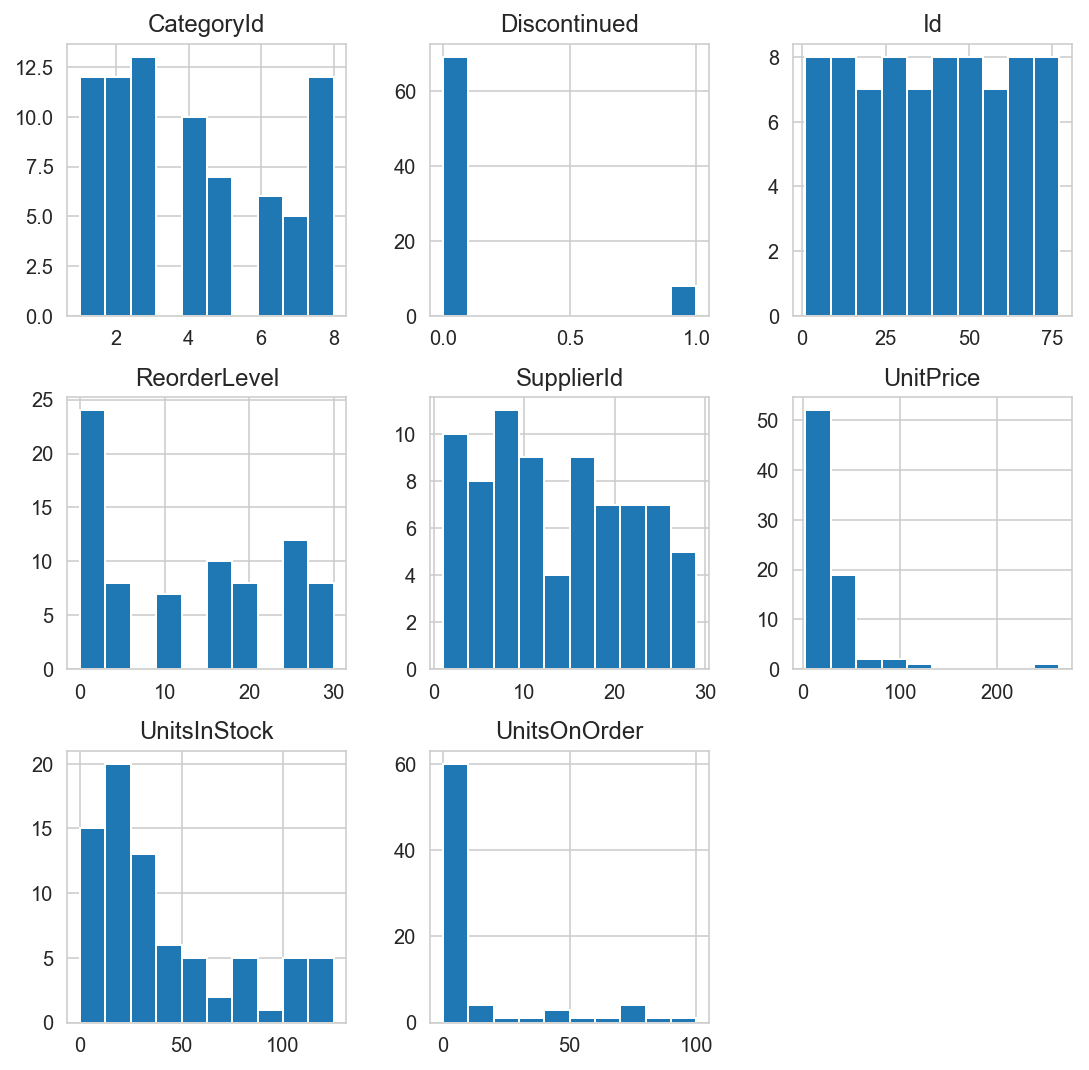

In [27]:
ax = product_df.hist(figsize=(9,9))

In [28]:
## Our goal is a marketing report rather than an operations report,  so removing columns regarding stock and reorders
product_df.drop(columns = ['UnitsInStock', 'UnitsOnOrder', 'ReorderLevel', 'Discontinued' ], inplace=True)

# Supplier Table
## There are 29 suppliers

In [29]:
select_text = 'SELECT * FROM Supplier;'
supplier_df = load_data(select_text)

Size of the dataframe =  (29, 12)
Number of null data
Id               0
CompanyName      0
ContactName      0
ContactTitle     0
Address          0
City             0
Region           0
PostalCode       0
Country          0
Phone            0
Fax             16
HomePage        24
dtype: int64
Number of duplicated data =  0


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


# Region Table
## 4 Regions (East, West, North, South)

In [30]:
select_data = 'SELECT * FROM Region;'
region_df = load_data(select_data)

Size of the dataframe =  (4, 2)
Number of null data
Id                   0
RegionDescription    0
dtype: int64
Number of duplicated data =  0


,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


# Category Table
## 8 Categories of edible goods


In [31]:
select_data = 'SELECT * FROM Category;'
category_df = load_data(select_data)

Size of the dataframe =  (8, 3)
Number of null data
Id              0
CategoryName    0
Description     0
dtype: int64
Number of duplicated data =  0


,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


# Order Detail Table
## One of the largest tables

## 2155 Products Sold


In [32]:
select_data = 'SELECT * FROM OrderDetail;'
orderdetail_df = load_data(select_data)

Size of the dataframe =  (2155, 6)
Number of null data
Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64
Number of duplicated data =  0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.000,12,0.000
1,10248/42,10248,42,9.800,10,0.000
2,10248/72,10248,72,34.800,5,0.000
3,10249/14,10249,14,18.600,9,0.000
4,10249/51,10249,51,42.400,40,0.000


## Value Counts for Order Detail

### display distribution of prices and discounts

In [33]:
for col in orderdetail_df.columns:
    print(col, '\n', orderdetail_df[col].value_counts().head(2200), '\n')
    #orderdetail_df[col].value_counts().plot(kind='bar', figsize=(3,3));

Id 
 10372/38    1
10626/60    1
10568/10    1
10909/41    1
10760/27    1
11057/70    1
10783/38    1
10463/19    1
10517/70    1
10423/59    1
10828/20    1
10861/21    1
10294/1     1
10695/12    1
10670/67    1
11024/71    1
10822/70    1
10521/35    1
10625/60    1
11009/60    1
10417/46    1
10979/27    1
10680/31    1
10672/38    1
10752/1     1
11055/51    1
10406/40    1
10627/62    1
10979/12    1
10869/68    1
           ..
10272/31    1
10794/14    1
10852/62    1
10312/53    1
10530/76    1
10905/1     1
10351/65    1
10681/19    1
10766/2     1
10793/52    1
10293/24    1
10468/30    1
10349/54    1
10767/42    1
10657/47    1
10879/40    1
10756/36    1
10273/33    1
11077/55    1
10486/11    1
10444/35    1
11067/41    1
10851/2     1
10338/17    1
10838/1     1
10951/41    1
10347/75    1
11069/39    1
10916/32    1
10842/68    1
Name: Id, Length: 2155, dtype: int64 

OrderId 
 11077    25
10657     6
10979     6
10847     6
10861     5
10558     5
11031     5
11021   

## Feature engineering.  We want to manipulate the data to compare populations with and without discounts shown in the OrderDetail
### Add a categorical column  called "Discounts" for discounts vs no discounts
### Add a Final Price column
### Add a total product spend column
### Plot a histogram of the data for visual inspection
    * >800 products were discounted, with the ranges of discounts from 5%-25%
    * Bins for significant discounts looks like 5,10,15,20,25

In [34]:
orderdetail_df['Discounts'] = np.where(orderdetail_df['Discount'] == 0,0,1)
orderdetail_df['Final Price'] = orderdetail_df['UnitPrice'] * (1 - orderdetail_df['Discount'])
orderdetail_df['Total Product Spend ($)'] = orderdetail_df['Final Price'] * orderdetail_df['Quantity']
orderdetail_df.head(20)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discounts,Final Price,Total Product Spend ($)
0,10248/11,10248,11,14.000,12,0.000,0,14.000,168.000
1,10248/42,10248,42,9.800,10,0.000,0,9.800,98.000
2,10248/72,10248,72,34.800,5,0.000,0,34.800,174.000
3,10249/14,10249,14,18.600,9,0.000,0,18.600,167.400
4,10249/51,10249,51,42.400,40,0.000,0,42.400,1.696k
5,10250/41,10250,41,7.700,10,0.000,0,7.700,77.000
6,10250/51,10250,51,42.400,35,150.000m,1,36.040,1.261k
7,10250/65,10250,65,16.800,15,150.000m,1,14.280,214.200
8,10251/22,10251,22,16.800,6,50.000m,1,15.960,95.760
9,10251/57,10251,57,15.600,15,50.000m,1,14.820,222.300


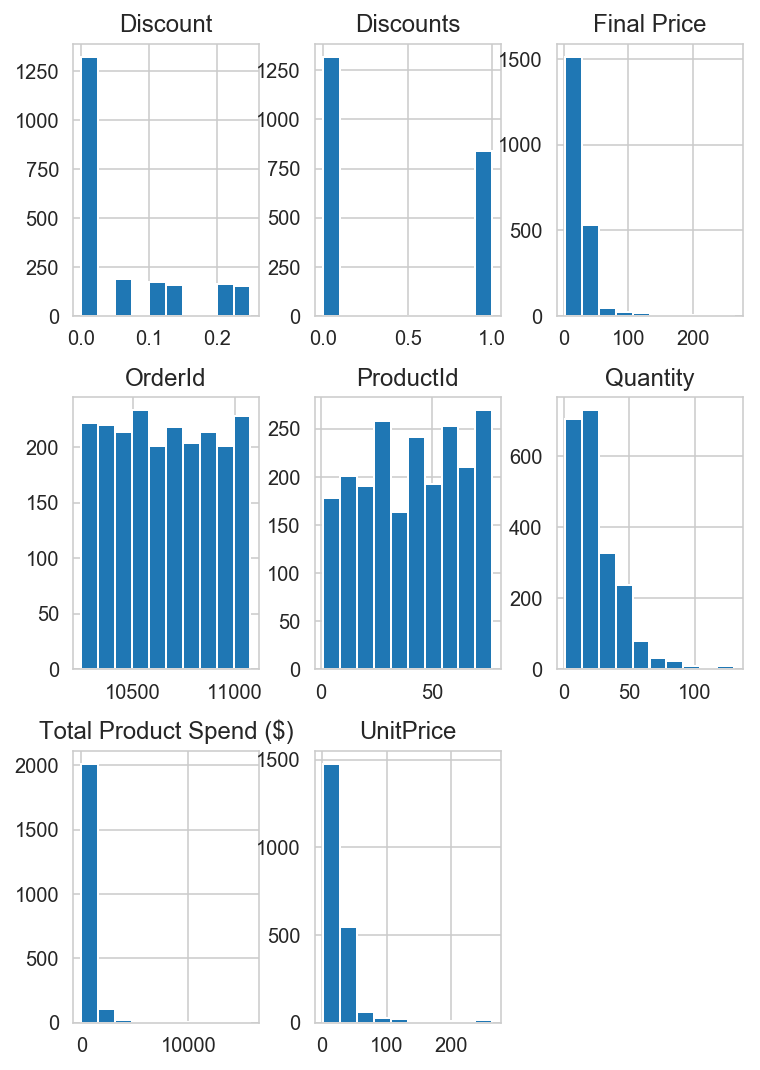

In [35]:
ax = orderdetail_df.hist(figsize=(6,9))

# Employees Table
## 9 Employees


In [36]:
select_data = 'SELECT * FROM Employee;'
Employee_df = load_data(select_data)

Size of the dataframe =  (9, 18)
Number of null data
Id                 0
LastName           0
FirstName          0
Title              0
TitleOfCourtesy    0
BirthDate          0
HireDate           0
Address            0
City               0
Region             0
PostalCode         0
Country            0
HomePhone          0
Extension          0
Photo              9
Notes              0
ReportsTo          1
PhotoPath          0
dtype: int64
Number of duplicated data =  0


,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.000,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.000,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.000,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.000,http://accweb/emmployees/buchanan.bmp


# Employee Territory Table

In [37]:
select_data = 'SELECT * FROM EmployeeTerritory;'
employee_territory_df = load_data(select_data)

Size of the dataframe =  (49, 3)
Number of null data
Id             0
EmployeeId     0
TerritoryId    0
dtype: int64
Number of duplicated data =  0


,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


# Territory Table

In [38]:
select_data = 'SELECT * FROM Territory;'
territory_df = load_data(select_data)


Size of the dataframe =  (53, 3)
Number of null data
Id                      0
TerritoryDescription    0
RegionId                0
dtype: int64
Number of duplicated data =  0


,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


# Customer Table
## 91 unique customers

In [39]:
select_data = 'SELECT * FROM Customer;'
customer_df = load_data(select_data)

Size of the dataframe =  (91, 11)
Number of null data
Id               0
CompanyName      0
ContactName      0
ContactTitle     0
Address          0
City             0
Region           0
PostalCode       1
Country          0
Phone            0
Fax             22
dtype: int64
Number of duplicated data =  0


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


# Shipper Table
## 3 Unique shippers

In [40]:
select_data = 'SELECT * FROM Shipper;'
shipper_df = load_data(select_data)



Size of the dataframe =  (3, 3)
Number of null data
Id             0
CompanyName    0
Phone          0
dtype: int64
Number of duplicated data =  0


,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


# Order Table
## 830 Customers

In [41]:
select_data = 'SELECT * FROM "Order" '
order_df = load_data(select_data)

Size of the dataframe =  (830, 14)
Number of null data
Id                 0
CustomerId         0
EmployeeId         0
OrderDate          0
RequiredDate       0
ShippedDate       21
ShipVia            0
Freight            0
ShipName           0
ShipAddress        0
ShipCity           0
ShipRegion         0
ShipPostalCode    19
ShipCountry        0
dtype: int64
Number of duplicated data =  0


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.380,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.610,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.830,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.340,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.300,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


Id                  int64
CustomerId         object
EmployeeId          int64
OrderDate          object
RequiredDate       object
ShippedDate        object
ShipVia             int64
Freight           float64
ShipName           object
ShipAddress        object
ShipCity           object
ShipRegion         object
ShipPostalCode     object
ShipCountry        object
dtype: object

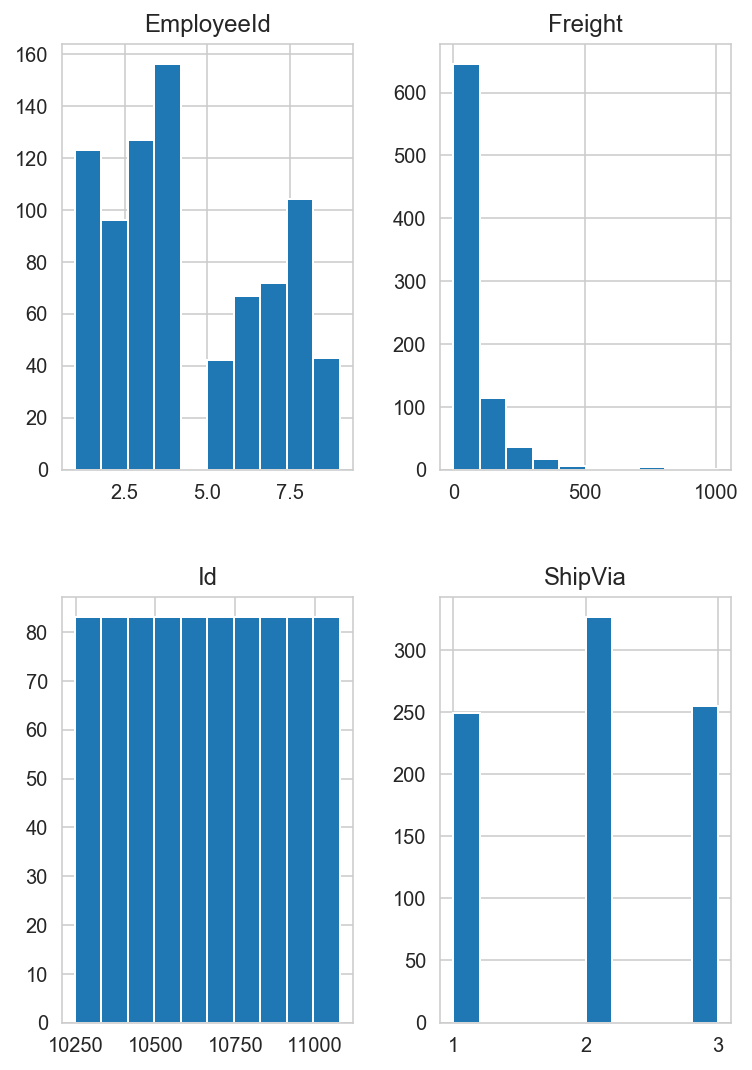

In [42]:
display(order_df.dtypes)
ax = order_df.hist(figsize = (6,9))

In [43]:
# Our goal is a marketing report rather than an operations report,  so removing less relevent columns
order_df.drop(columns = ['ShipAddress', 'ShipCity', 'ShipPostalCode', 'Freight' ], inplace=True)

In [44]:
order_df['CustomerId'].unique()


array(['VINET', 'TOMSP', 'HANAR', 'VICTE', 'SUPRD', 'CHOPS', 'RICSU',
       'WELLI', 'HILAA', 'ERNSH', 'CENTC', 'OTTIK', 'QUEDE', 'RATTC',
       'FOLKO', 'BLONP', 'WARTH', 'FRANK', 'GROSR', 'WHITC', 'SPLIR',
       'QUICK', 'MAGAA', 'TORTU', 'MORGK', 'BERGS', 'LEHMS', 'ROMEY',
       'LILAS', 'RICAR', 'REGGC', 'BSBEV', 'COMMI', 'TRADH', 'HUNGO',
       'WANDK', 'GODOS', 'OLDWO', 'LONEP', 'ANATR', 'THEBI', 'DUMO',
       'ISLAT', 'PERIC', 'KOENE', 'SAVEA', 'BOLID', 'FURIB', 'BONAP',
       'MEREP', 'PRINI', 'SIMOB', 'FAMIA', 'LAMAI', 'PICCO', 'AROUT',
       'SEVES', 'DRACD', 'EASTC', 'ANTO', 'GALED', 'VAFFE', 'QUEE',
       'WOLZA', 'HUNGC', 'SANTG', 'BOTTM', 'LINOD', 'FOLIG', 'OCEA',
       'FRANS', 'GOURL', 'CONSH', 'RANCH', 'LAZYK', 'LAUGB', 'BLAUS',
       'NORTS', 'CACTU', 'GREAL', 'MAISD', 'TRAIH', 'LETSS', 'WILMK',
       'THECR', 'ALFKI', 'FRANR', 'SPECD', 'LACOR'], dtype=object)

## 741 Repeat Customers

In [45]:
order_df['CustomerId'].duplicated().value_counts()


True     741
False     89
Name: CustomerId, dtype: int64

In [46]:
order_df['ShipName'].duplicated().value_counts()

True     740
False     90
Name: ShipName, dtype: int64

In [47]:
order_df['ShipCountry'].duplicated().value_counts()

True     809
False     21
Name: ShipCountry, dtype: int64

## Top Sales People (by # of Orders)

### Western Europe is the top region for orders (276),  North America (152), and South America (145)

### United States and Germany are tied for the largest customer base (122)

In [48]:
for col in order_df.columns:
    print(col, "\n", order_df[col].value_counts().head(900), "\n")

Id 
 11077    1
10520    1
10530    1
10529    1
10528    1
10527    1
10526    1
10525    1
10524    1
10523    1
10522    1
10521    1
10519    1
10532    1
10518    1
10517    1
10516    1
10515    1
10514    1
10513    1
10512    1
10511    1
10510    1
10509    1
10531    1
10533    1
10507    1
10546    1
10556    1
10555    1
        ..
10772    1
10771    1
10770    1
10769    1
10791    1
10792    1
10793    1
10794    1
10815    1
10814    1
10813    1
10812    1
10811    1
10810    1
10809    1
10808    1
10807    1
10806    1
10805    1
10804    1
10803    1
10802    1
10801    1
10800    1
10799    1
10798    1
10797    1
10796    1
10795    1
10248    1
Name: Id, Length: 830, dtype: int64 

CustomerId 
 SAVEA    31
ERNSH    30
QUICK    28
HUNGO    19
FOLKO    19
BERGS    18
HILAA    18
RATTC    18
BONAP    17
LEHMS    15
WARTH    15
FRANK    15
LILAS    14
LAMAI    14
HANAR    14
WHITC    14
BOTTM    14
KOENE    14
QUEE     13
AROUT    13
MEREP    13
LINOD    12
REGGC    

# Customer Demographic tables do not exist

In [49]:
select_data = 'SELECT * FROM CustomerDemographic;'
customer_demographic_df = load_data(select_data)

Table not loaded


In [50]:
select_data = 'SELECT * FROM CustomerCustomerDemo LIMIT 5;'
ccustomer_demo_df = load_data(select_data)



Table not loaded


# Defined Functions

In [51]:
# Define generic functions to do simple statistics evaluations on 2 sample comparisons between features and metrics
# The purpose is to see if specific feature has a significant effect on a metric (example feature : discount)
# An example of the metric is "Order Quantity" or "Total Product Spend ($)"
# This is an example of univariate analysis where we check for the significance of a single feature while all other
# effects are not taken into account 

def two_sample_tests(df, feature, metric, alpha = 0.05): 
    group1 = df.groupby(feature).get_group(0)[metric]
    group2 = df.groupby(feature).get_group(1)[metric]
    
    print(f'Number of datapoints in group 1, no {feature} = {len(group1)}')
    print(f'Number of datapoints in group 2, with {feature} = {len(group2)}')
       
    if (len(group1) or len(group2)) > 20:
        print("Number of datapoints in the samples > 30, possible to assume normality through the Central Limit Theorem", '\n')
        print("Check the normality anyway!")    
        
# Run the test for a normal distribution        
    normtest_p1, normtest_p2 = normdist_test(group1, group2, alpha)

# Check for the equivalence of the populations in terms of mean and variance, using Levene test, 
# Then check the equivalence of the populations using either MannWhitneyU or the 2-tailed T-test

    levene_test(group1, group2, alpha)
    
    if (normtest_p1 or normtest_p2) < alpha:
        print("Need to use the non-parametric test (Mann-WhitneyU) to determine the equivalence of the populations", '\n')
        mannwhitney_test(group1, group2, alpha)
        
    else:
        print("Since the distributions are normal, proceed with the 2 sample t-test")
        t_test(group1, group2, alpha)
        
    return group1, group2


def normdist_test(group1, group2, alpha): 
    
    sns.distplot(group1)
    plt.show()
    stat_test1, normtest_p1 = stat.normaltest(group1)
    
    if normtest_p1 < alpha:
        print(f"Sample 1 P-value {normtest_p1} is less than alpha {alpha}")
        print(f"Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution", '\n')
    else:
        print("Sample 1 Normality: We can accept the null hypothesis that the 1st sample comes from a normal distribution", '\n')
    
    sns.distplot(group2)
    plt.show()
    
    stat_test2, normtest_p2 = stat.normaltest(group2)
    
    if normtest_p2 < alpha:
        print(f"Sample 2 P-value {normtest_p1} is less than alpha {alpha}")
        print(f"Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution", '\n')
    else:
        print("Sample 2 Normality: We can accept the null hypothesis that the 2nd samples comes from a normal distribution", '\n')
        
    return normtest_p1, normtest_p2
        
def mannwhitney_test(group1, group2, alpha):
    mw_stat, mw_p = stat.mannwhitneyu(group1, group2)
    print(f"MWU: The U statistic is {mw_stat}, and the p-value is {mw_p}")
    if mw_p < alpha:
        print(f"MWU: The MannWhitneyU p-value {mw_p} is less than alpha {alpha}")
        print("MannWhitneyU test: We can reject the null hypothesis that the two populations are equal",'\n')
    else:
        print("MannWhitneyU test: We can accept the null hypothesis that the two populations are equal",'\n')
        
    return 
          
# This is a Two-tailed T-Test,  whether two groups are equivalent to one another
# https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/hypothesis-testing/one-tailed-test-or-two/

def t_test(group1, group2, alpha):  
    # Usage: t_test
    ttest_stat, ttest_p = stat.ttest_ind(group1, group2)
    if ttest_p < alpha:
        print(f"The 2-tailed T-test p value {ttest_p}, is less than alpha {alpha}")
        print("The 2-tailed T-test: We reject the null hypothesis that the populations have identical variance",'\n')
    else:
        print("The 2-tailed T-test: We accept the null hypthesis that the populations have identical variance",'\n')

        
    return
          
          
def levene_test(group1, group2, alpha):
    levene_stat, levene_p = stat.levene(group1, group2)
    if levene_p < alpha:
        print(f"The Levene p-value, {levene_p} is less than alpha {alpha}")
        print("Levene test: We reject the null hypothesis that the variances are equal",'\n')
    else:
        print("Levene test: We accept the null hypothesis that the variances of the populations equal", '\n')
        
    return

#Plot the data, with standard error of measurement (sem)

def plot_two_sample_tests(group1, group2, feature, metric):
    #pd.options.display.float_format = '{:.1f}'.format
    pd.options.display.float_format = '{:,.2f}'.format
    print(f'The average {metric} sold, without {feature} is {group1.mean()}')
    print(f'The average {metric} sold, with {feature} is {group2.mean()}')
    
    
   
    plt.bar(x=f'Without {feature}', height = group1.mean(), yerr = stat.sem(group1))
    plt.bar(x=f'With {feature}', height = group2.mean(), yerr = stat.sem(group2))
    
    plt.title(f'Effect of {feature} on {metric}')
    plt.ylabel(f'Average {metric}');
    
    return         


# Hypothesis 1: Does discount have a significant impact on the quantity ordered?

## The null hypothesis H0 is that the discount has no significant impact on quantity ordered.
## The alternative hypthesis H1 is that discount does have a significant impact on quantity ordered.

Number of datapoints in group 1, no Discounts = 1317
Number of datapoints in group 2, with Discounts = 838
Number of datapoints in the samples > 30, possible to assume normality through the Central Limit Theorem 

Check the normality anyway!


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


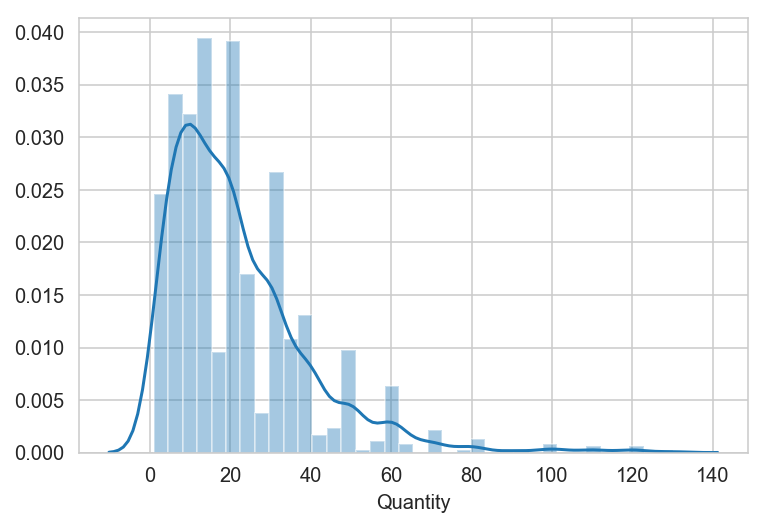

Sample 1 P-value 5.579637380545965e-119 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



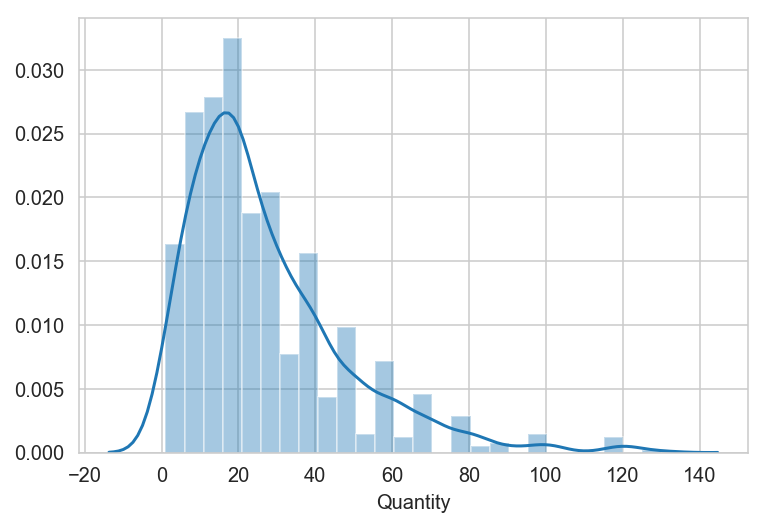

Sample 2 P-value 5.579637380545965e-119 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 

The Levene p-value, 0.00012091378376079568 is less than alpha 0.05
Levene test: We reject the null hypothesis that the variances are equal 

Need to use the non-parametric test (Mann-WhitneyU) to determine the equivalence of the populations 

MWU: The U statistic is 461541.0, and the p-value is 6.629381826999866e-11
MWU: The MannWhitneyU p-value 6.629381826999866e-11 is less than alpha 0.05
MannWhitneyU test: We can reject the null hypothesis that the two populations are equal 

The average Quantity sold, without Discounts is 21.715261958997722
The average Quantity sold, with Discounts is 27.10978520286396


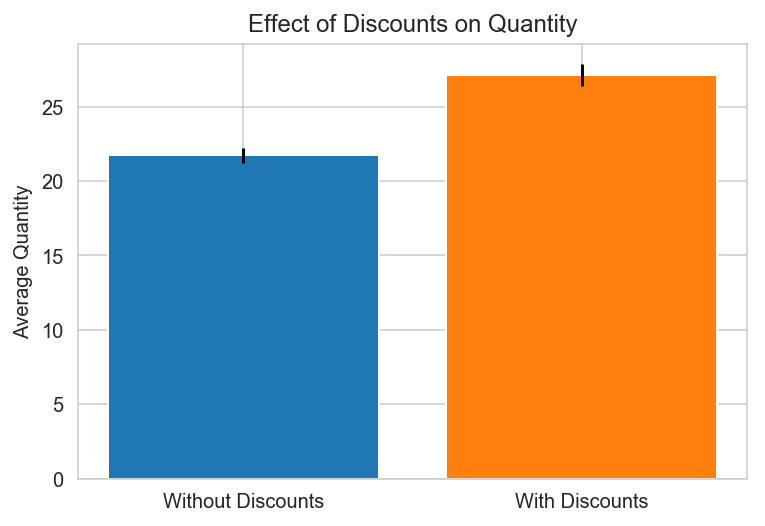

In [52]:
# Use the functions built to perform the analysis automatically

no_discount, with_discount = two_sample_tests(orderdetail_df, 'Discounts', 'Quantity')
plot_two_sample_tests(no_discount, with_discount, "Discounts", "Quantity")


## Calculate which Levels of discount are significant 

In [53]:
# The lack of overlap of confidence intervals agrees with the above test
# The difference in average quantity not due to random chance of 5% or more

# Now calculate which levels of discount are significant towards increasing the quantity
# Use of Tukey's test

data = orderdetail_df['Quantity'].values
labels = orderdetail_df['Discount'].values

print(data), print(labels)

import statsmodels.api as sms

model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)
model.summary()


[12 10  5 ...  2  4  2]
[0.   0.   0.   ... 0.01 0.   0.  ]


group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
0.0,0.05,6.2955,0.0011,1.5381,11.053,True
0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
0.0,0.15,6.6669,0.0014,1.551,11.7828,True
0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
0.0,0.25,6.525,0.0023,1.3647,11.6852,True


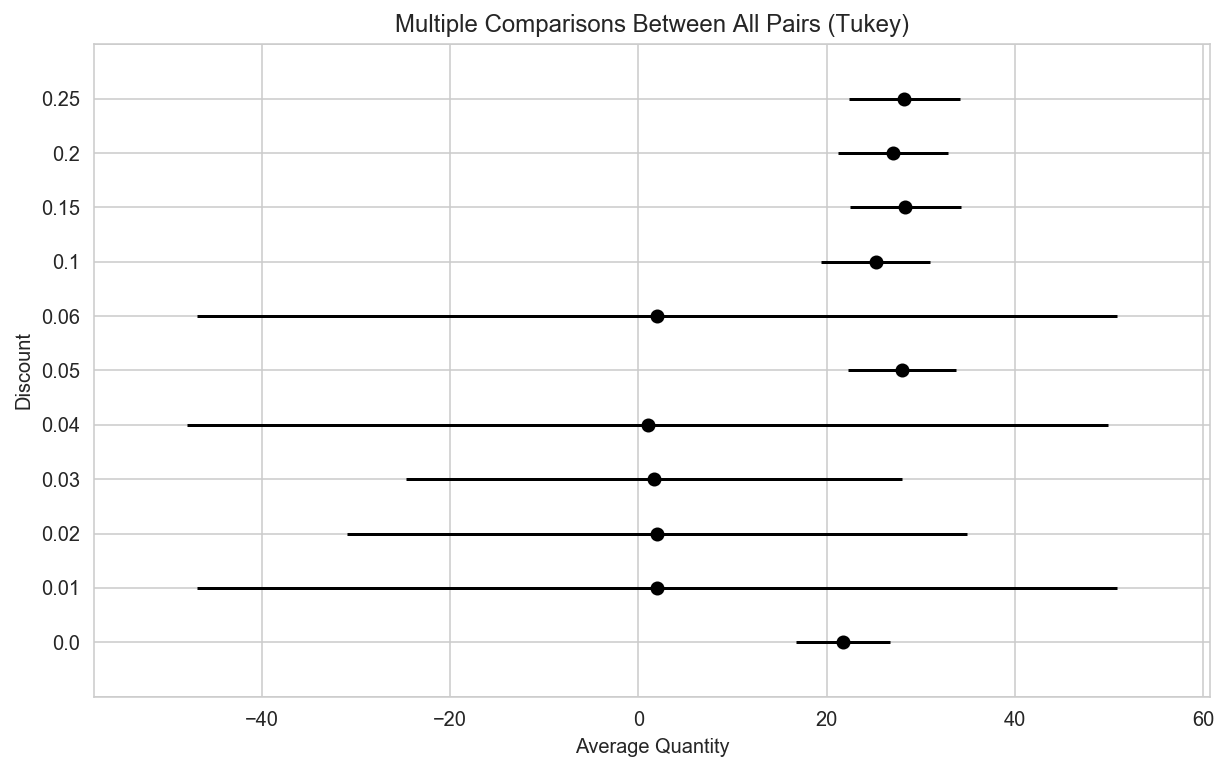

In [54]:
model.plot_simultaneous()
plt.ylabel('Discount')
plt.xlabel('Average Quantity');

## Hypothesis 1 Results

### Reject the null hypothesis that discounted and undiscounted products have similar quantities

### Only 5%, 15%, 20%, and 25% discounts have significant impact on the average order quantity

### Interestingly a 10% discount does not appear to have a significant effect relative to no discount


# Hypothesis 2:  Does discount impact the total amount a customer will spend (Total Product Spend) ?

Number of datapoints in group 1, no Discounts = 1317
Number of datapoints in group 2, with Discounts = 838
Number of datapoints in the samples > 30, possible to assume normality through the Central Limit Theorem 

Check the normality anyway!


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


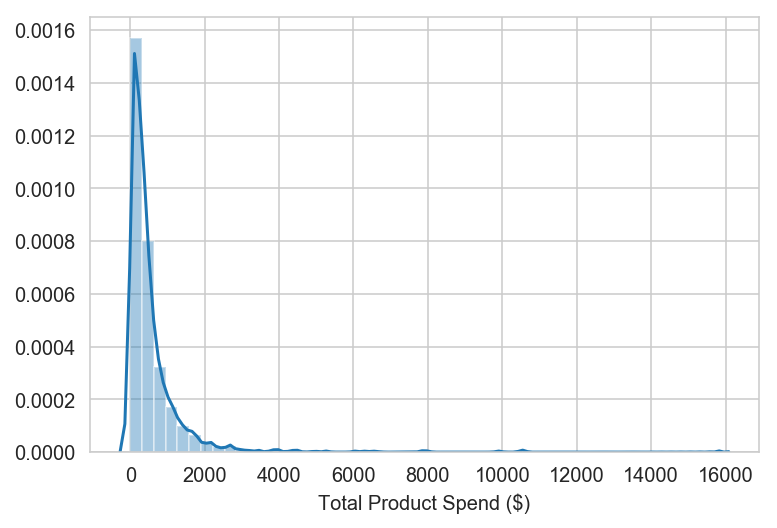

Sample 1 P-value 0.0 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



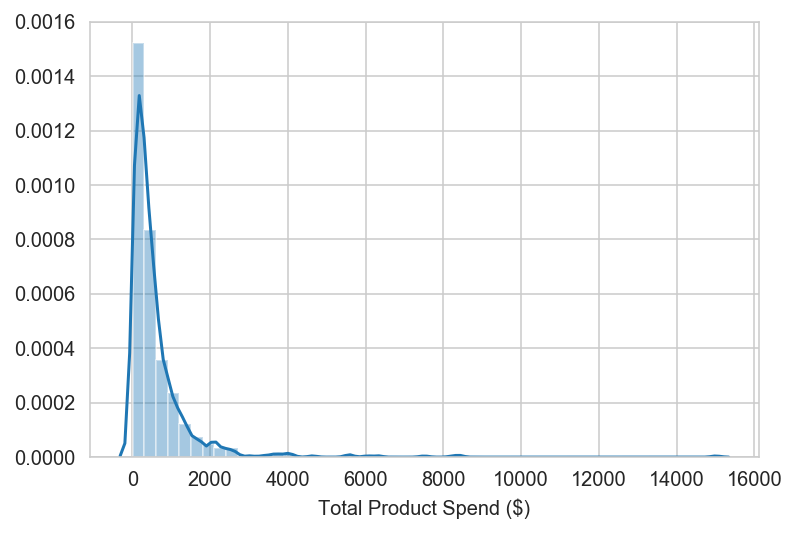

Sample 2 P-value 0.0 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 

Levene test: We accept the null hypothesis that the variances of the populations equal 

Need to use the non-parametric test (Mann-WhitneyU) to determine the equivalence of the populations 

MWU: The U statistic is 525843.5, and the p-value is 0.03252534474485538
MWU: The MannWhitneyU p-value 0.03252534474485538 is less than alpha 0.05
MannWhitneyU test: We can reject the null hypothesis that the two populations are equal 

The average Total Product Spend ($)  sold, without Discounts is 570.0065375854215
The average Total Product Spend ($)  sold, with Discounts is 614.671156921241


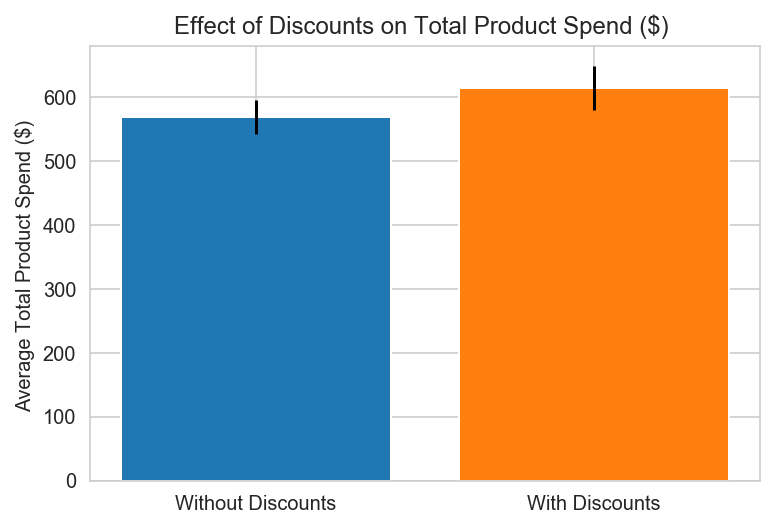

In [55]:
# Use the functions built to perform the analysis automatically

no_disc_rev_impact, with_disc_rev_impact = two_sample_tests(orderdetail_df, 'Discounts', 'Total Product Spend ($)')

plot_two_sample_tests(no_disc_rev_impact, with_disc_rev_impact, 'Discounts', 'Total Product Spend ($) ')

## The overlap of confidence intervals agrees with the above test, that the impact of discount on product revenue is not significant

## We aren't able to reject the null hypothesis.  There effect of discounts on customer spending appears to be insignificant.

## No need to test whether specific discounts might have impact on the product revenue


In [56]:
# Tukey tests show that none of the different discounts has a meaningful impact on the Total Product Spend
data = orderdetail_df['Total Product Spend ($)'].values 
labels = orderdetail_df['Discount'].values

print(data), print(labels)

import statsmodels.api as sms

model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels) 
model.summary()

[168.   98.  174.  ...  29.7  31.   26. ]
[0.   0.   0.   ... 0.01 0.   0.  ]


group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-540.3065,0.9,-3662.2549,2581.6418,False
0.0,0.02,-540.1165,0.9,-2748.5047,1668.2716,False
0.0,0.03,-529.703,0.9,-2333.5278,1274.1217,False
0.0,0.04,-492.2465,0.9,-3614.1949,2629.7018,False
0.0,0.05,227.9252,0.0954,-17.1036,472.954,False
0.0,0.06,-506.0865,0.9,-3628.0349,2615.8618,False
0.0,0.1,-41.1098,0.9,-293.48,211.2604,False
0.0,0.15,-12.6424,0.9,-276.1341,250.8493,False
0.0,0.2,-16.0866,0.9,-276.6374,244.4641,False
0.0,0.25,72.4517,0.9,-193.3232,338.2266,False


## Summary:  Discounts have no significant effect on customers' product spend


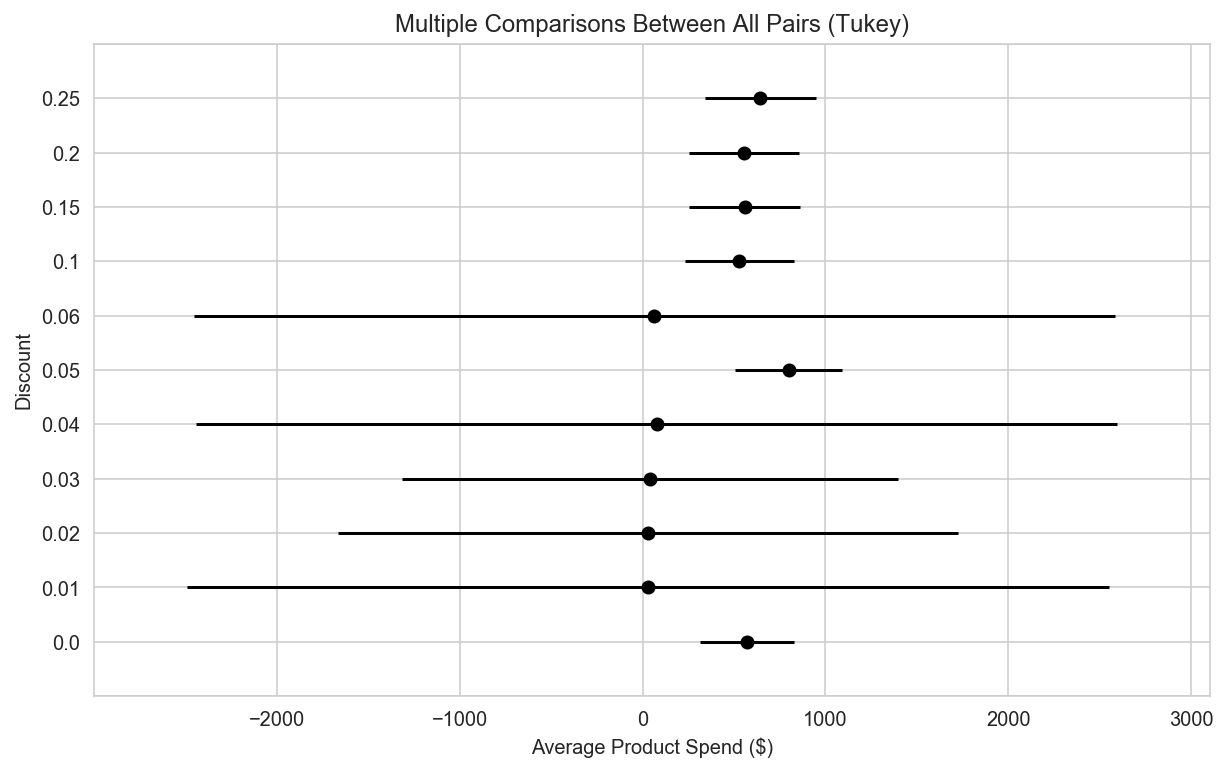

In [57]:
model.plot_simultaneous()
plt.ylabel('Discount')
plt.xlabel('Average Product Spend ($)');

# Hypothesis 3 : What is the impact of "Net Discount" on the Quantity?

## Joining the orderdetail and product tables shows that some products were sold with a price lower than the MSRP (Manufacturers Suggested Retail Price),  and some had additional discounts

## When we look at the joined tables below, we see there are actually 4 different pricing strategies:  No Discounts, Other discounts only, MSRP discounts only,  Both type of discounts


## Create new categorical column "MSRP"  (1 = MSRP price, 0 = MSRP discounted)
## Create new categorical column "net_discount" (1 = has some kind of discount, 0 = no discounts)

In [58]:
display(orderdetail_df.head())
display(product_df.head(11))

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discounts,Final Price,Total Product Spend ($)
0,10248/11,10248,11,14.00,12,0.00,0,14.00,168.00
1,10248/42,10248,42,9.80,10,0.00,0,9.80,98.00
2,10248/72,10248,72,34.80,5,0.00,0,34.80,174.00
3,10249/14,10249,14,18.60,9,0.00,0,18.60,167.40
4,10249/51,10249,51,42.40,40,0.00,0,42.40,"1,696.00"


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice
0,1,Chai,1,1,10 boxes x 20 bags,18.00
1,2,Chang,1,1,24 - 12 oz bottles,19.00
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35
5,6,Grandma's Boysenberry Spread,3,2,12 - 8 oz jars,25.00
6,7,Uncle Bob's Organic Dried Pears,3,7,12 - 1 lb pkgs.,30.00
7,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.00
8,9,Mishi Kobe Niku,4,6,18 - 500 g pkgs.,97.00
9,10,Ikura,4,8,12 - 200 ml jars,31.00


In [59]:
#select_data = 'SELECT * FROM OrderDetail od JOIN "Order" ON od.OrderId = "Order".Id JOIN Product p ON od.ProductId = p.Id;'
#ordetail_ord_prod_df = load_data(select_data)
#ordetail_ord_prod_df.head()

# Use pandas to join orderdetail_df to product_df to take advantage of the added columns in orderdetails_df and because Pandas 
# creates unique column names
order_product_df = orderdetail_df.merge(product_df, left_on='ProductId', right_on='Id')

# Create a new column called "Net Discounts" and a categorical net_discount
order_product_df['Net Discounts'] = 1 - (order_product_df['Final Price'] / order_product_df['UnitPrice_y'])
order_product_df['net_discount'] = np.where(order_product_df['Net Discounts'] == 0,0,1)

# Create a new column MSRP Discount and cateogorical column that calculates the discount based on price only
# The categorical checks whether the order is using the MSRP or not
order_product_df['MSRP Discount'] = 1 - (order_product_df['UnitPrice_x'] / order_product_df['UnitPrice_y'])
order_product_df['MSRP'] = np.where(order_product_df["UnitPrice_x"] == order_product_df["UnitPrice_y"], 1, 0)

order_product_df.head(50)



,Id_x,OrderId,ProductId,UnitPrice_x,Quantity,Discount,Discounts,Final Price,Total Product Spend ($),Id_y,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_y,Net Discounts,net_discount,MSRP Discount,MSRP
0,10248/11,10248,11,14.00,12,0.00,0,14.00,168.00,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.33,1,0.33,0
1,10296/11,10296,11,16.80,12,0.00,0,16.80,201.60,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.20,1,0.20,0
2,10327/11,10327,11,16.80,50,0.20,1,13.44,672.00,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.36,1,0.20,0
3,10353/11,10353,11,16.80,12,0.20,1,13.44,161.28,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.36,1,0.20,0
4,10365/11,10365,11,16.80,24,0.00,0,16.80,403.20,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.20,1,0.20,0
5,10407/11,10407,11,16.80,30,0.00,0,16.80,504.00,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.20,1,0.20,0
6,10434/11,10434,11,16.80,6,0.00,0,16.80,100.80,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.20,1,0.20,0
7,10442/11,10442,11,16.80,30,0.00,0,16.80,504.00,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.20,1,0.20,0
8,10443/11,10443,11,16.80,6,0.20,1,13.44,80.64,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.36,1,0.20,0
9,10466/11,10466,11,16.80,10,0.00,0,16.80,168.00,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.20,1,0.20,0


## Plot to see the distributions for:
### Group 1 - No discounts whatsoever
### Group 2 - MSRP with discounts
### Group 3 - Discounted MSRP and no other discounts
### Group 4 - Both discounted MSRP and other discounts

In [60]:
#df_new = df.drop(df[(df['col_1'] == 1.0) & (df['col_2'] == 0.0)].index)
#print(df_new)
#df = df.loc[~((df['col_1'] == 1.0) & (df['col_2'] == 0.0)),:]

no_discounts_df = order_product_df.loc[(order_product_df['net_discount'] == 0),:]
discount_only_df = order_product_df.loc[((order_product_df['MSRP'] == 1) & (order_product_df['Discounts'] ==1)), :]
MSRP_disc_only_df = order_product_df.loc[((order_product_df['MSRP'] == 0) & (order_product_df['Discounts']==0)), :]
both_discounts_df = order_product_df.loc[((order_product_df['MSRP'] == 0) & (order_product_df['Discounts'] == 1)), :]

def four_samples_comparison(metric, alpha):
    group1 = no_discounts_df[metric]
    group2 = discount_only_df[metric]
    group3 = MSRP_disc_only_df[metric]
    group4 = both_discounts_df[metric]
    print(f'The population size for group 1 is {len(group1)}, and for group 2 is {len(group2)}')
    print(f'The population size for group 3 is {len(group3)}, and for group 4 is {len(group4)}')
    
    normdist_test(group1, group2, alpha)
    normdist_test(group3, group4, alpha)
    
    plt.bar(x='No Discounts', height = group1.mean(), yerr = stat.sem(group1))
    plt.bar(x='Other Discount Only', height = group2.mean(), yerr = stat.sem(group2))
    plt.bar(x='MSRP Discount Only', height = group3.mean(), yerr = stat.sem(group3))    
    plt.bar(x='Both Discounts', height = group4.mean(), yerr = stat.sem(group4))

    plt.title(f'Comparison of Impact of Discount Types on {metric}S')
    plt.ylabel(f'Average {metric}');
    
    return group1, group2, group3, group4

The population size for group 1 is 915, and for group 2 is 582
The population size for group 3 is 402, and for group 4 is 256


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


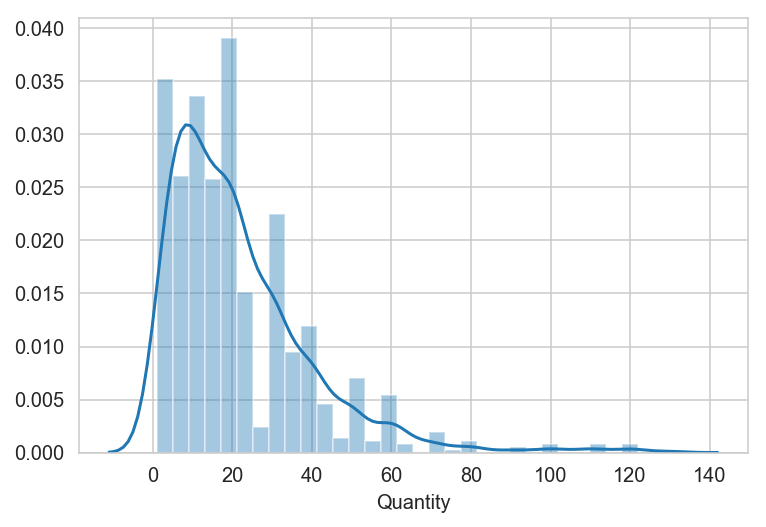

Sample 1 P-value 9.269039017041992e-89 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



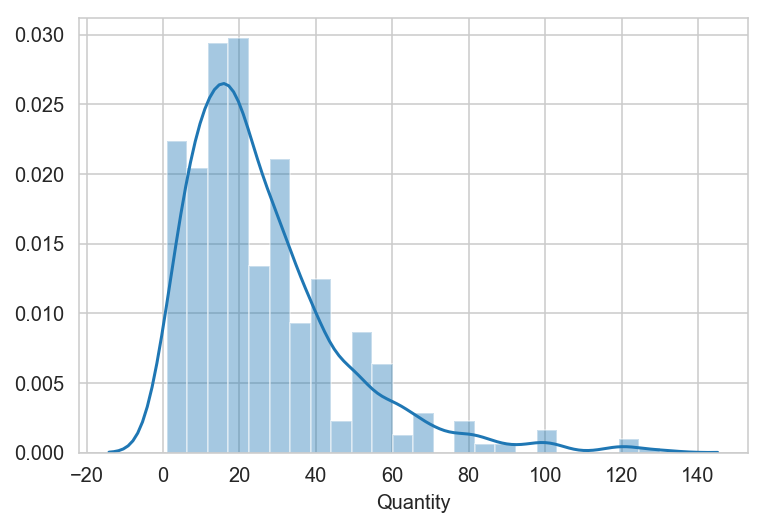

Sample 2 P-value 9.269039017041992e-89 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 



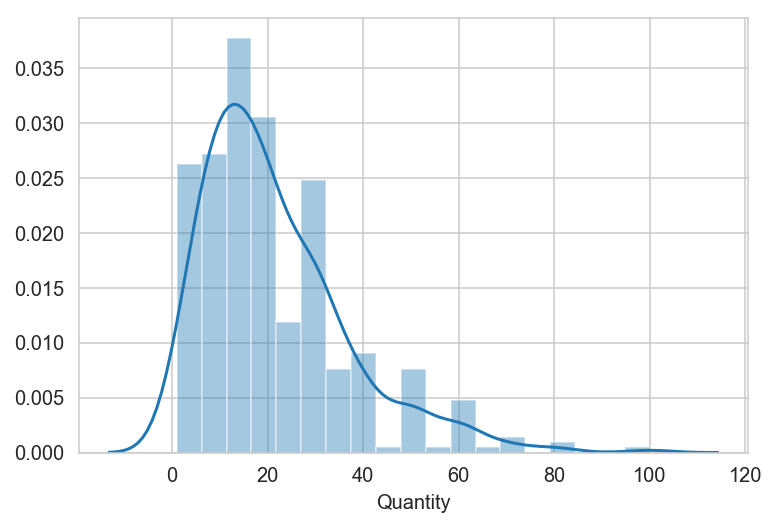

Sample 1 P-value 7.774633648183358e-25 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



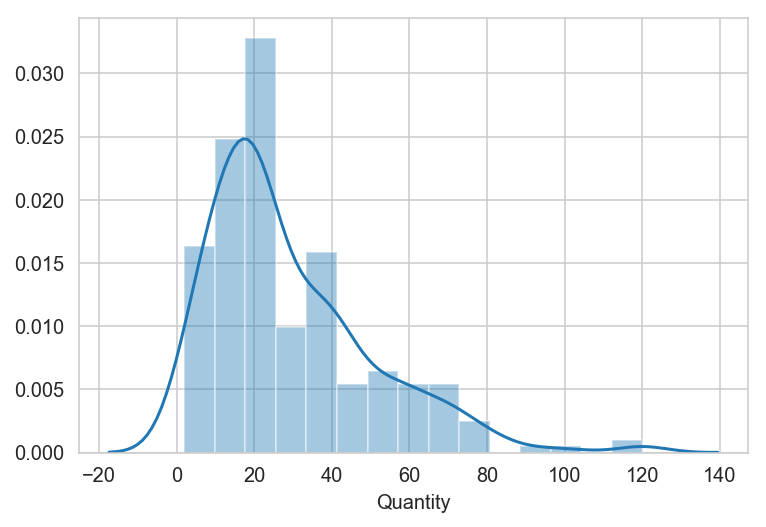

Sample 2 P-value 7.774633648183358e-25 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 



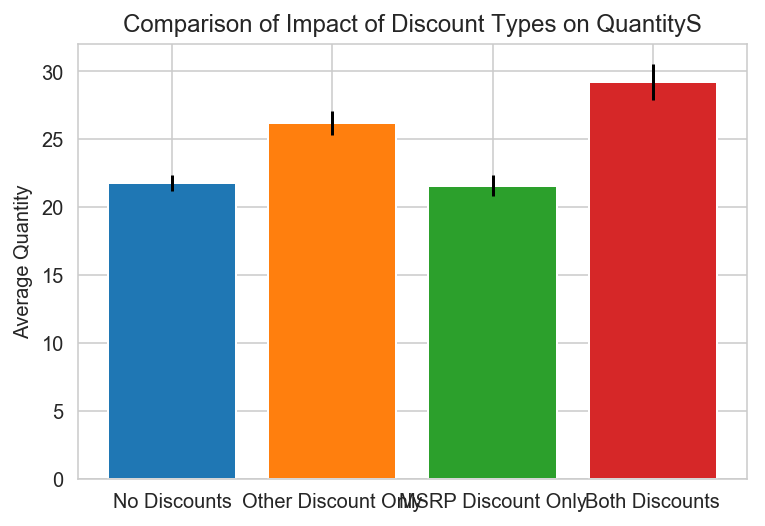

In [61]:
no_disc, other_disc, MSRP_disc, all_discs = four_samples_comparison('Quantity', alpha)

In [62]:
# Use ANOVA to check the similarity of the populations

fstat, pval = stat.f_oneway(no_disc, other_disc, MSRP_disc, all_discs)
print(fstat, pval)
if pval < alpha:
    print(f"The null hypothesis is rejected that there is no difference between the groups and the means are equal")
    print("The populations and means are not equivalent")
else:
    print(f"The null hypothesis is accepted that there is no difference between the groups, and the means are equal")

15.50787532818146 5.56608507477635e-10
The null hypothesis is rejected that there is no difference between the groups and the means are equal
The populations and means are not equivalent


The population size for group 1 is 915, and for group 2 is 582
The population size for group 3 is 402, and for group 4 is 256


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


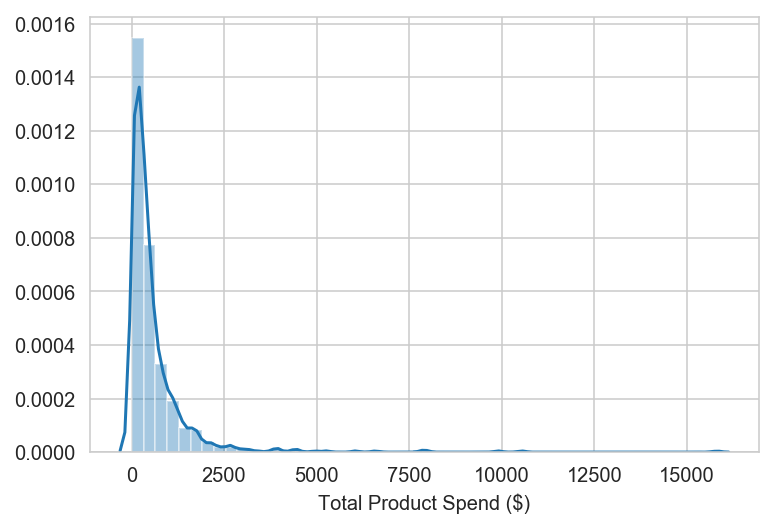

Sample 1 P-value 7.972762931381562e-264 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



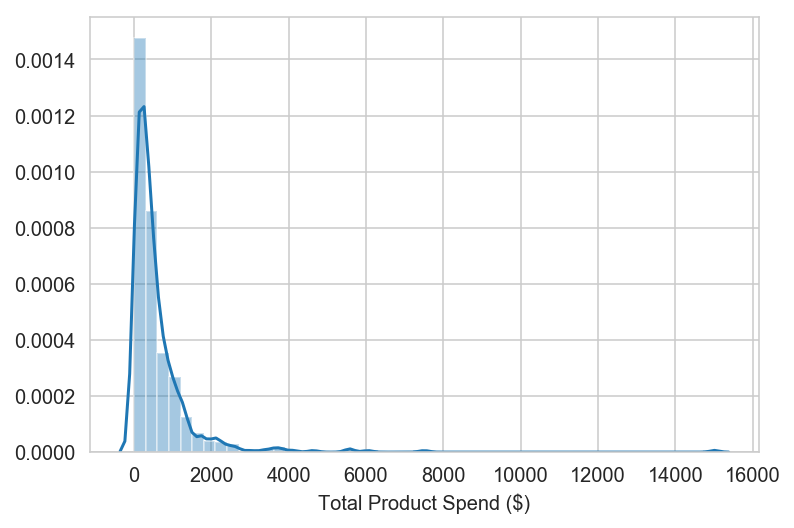

Sample 2 P-value 7.972762931381562e-264 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 



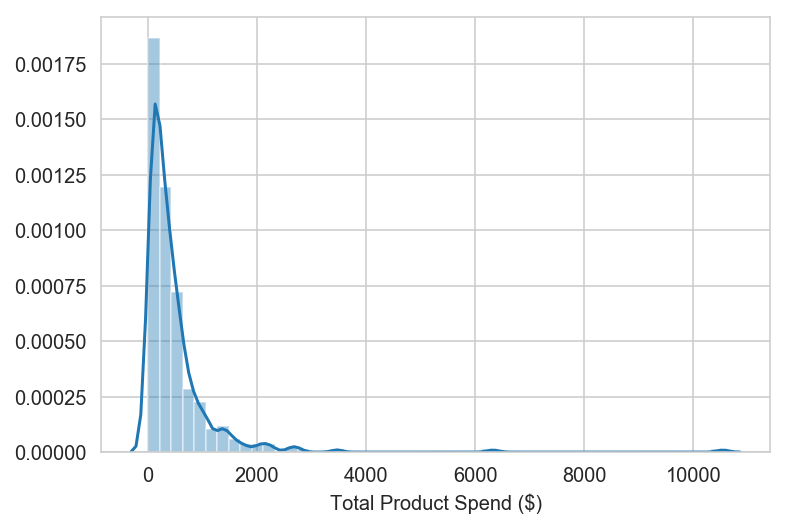

Sample 1 P-value 1.2126946852158827e-129 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



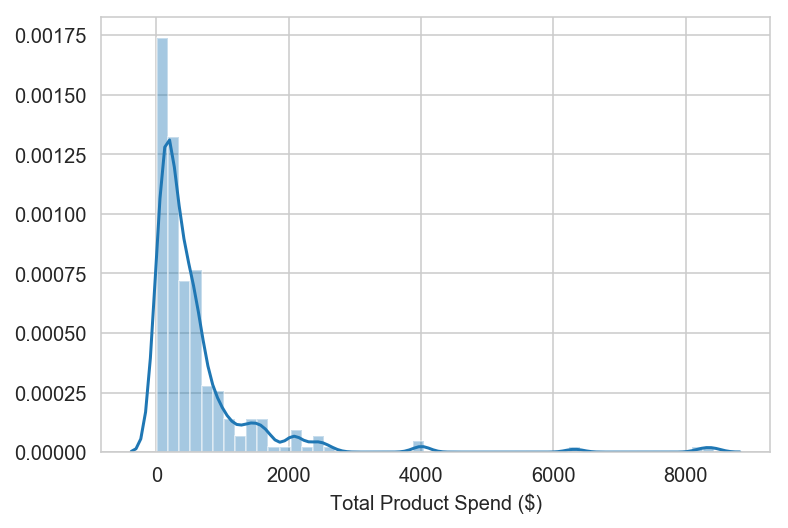

Sample 2 P-value 1.2126946852158827e-129 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 



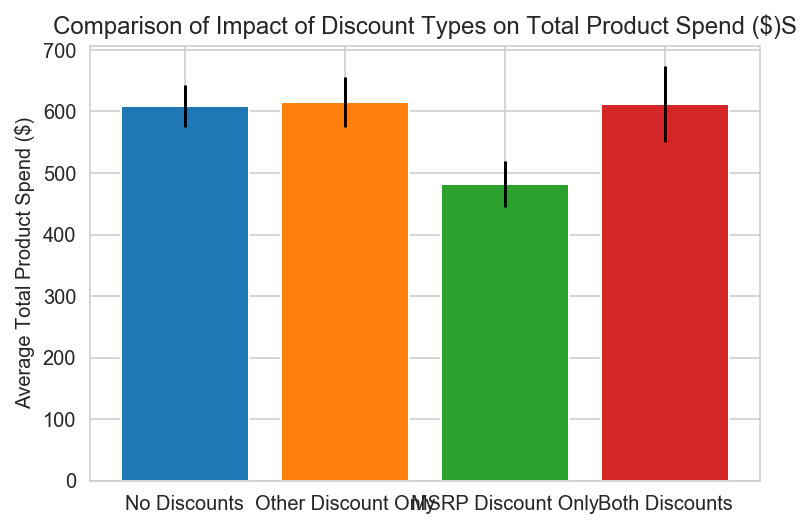

In [63]:
rev1, rev2, rev3, rev4 = four_samples_comparison('Total Product Spend ($)', alpha)

In [64]:
fstat, pval = stat.f_oneway(rev1, rev2, rev3, rev4)
print(fstat, pval)
if pval < alpha:
    print(f"The null hypothesis is rejected that there is no difference between the groups and the means are equal")
else:
    print(f"The null hypothesis is accepted that there is no difference between the groups, and the means are equal")

1.9497649299486008 0.11951841800067911
The null hypothesis is accepted that there is no difference between the groups, and the means are equal


## Result - there is a significant difference between discounting methods.
## MSRP discounting was the least effective in generating more orders.

## Other discounts as well as combined MSRP and other discounts were effective
## strategies to get more orders

## Discounting has no significant impact on improving product sales.  There was no significant difference between no discounts, and other discounts.  Interestingly,  the MSRP discount had a significant level of lower revenue. 

### Thus, it was a good idea to move away from simply lowering the prices on the MSRP, which suggest the price is a baseline price, everyday price.   Instead position the reductions in prices as "temporary price reductions.


##  Check to see the effect of MSRP discounts on Order Quantity and Product Spend

Number of datapoints in group 1, no MSRP = 658
Number of datapoints in group 2, with MSRP = 1497
Number of datapoints in the samples > 30, possible to assume normality through the Central Limit Theorem 

Check the normality anyway!


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


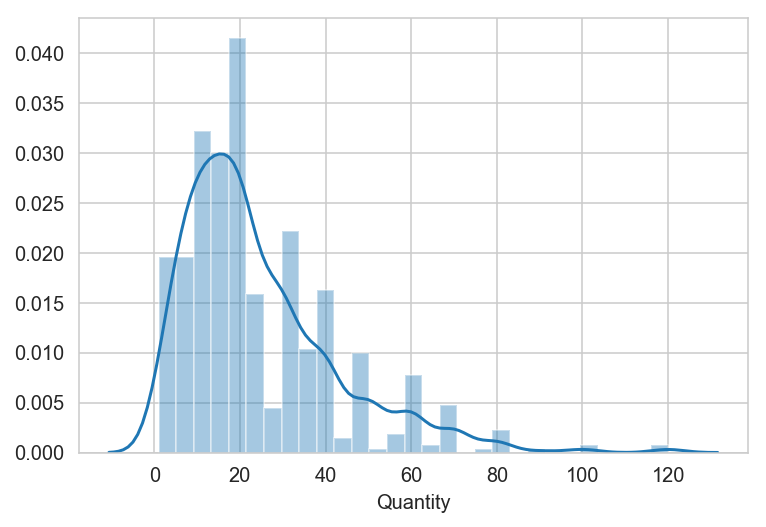

Sample 1 P-value 4.3519853073007804e-44 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



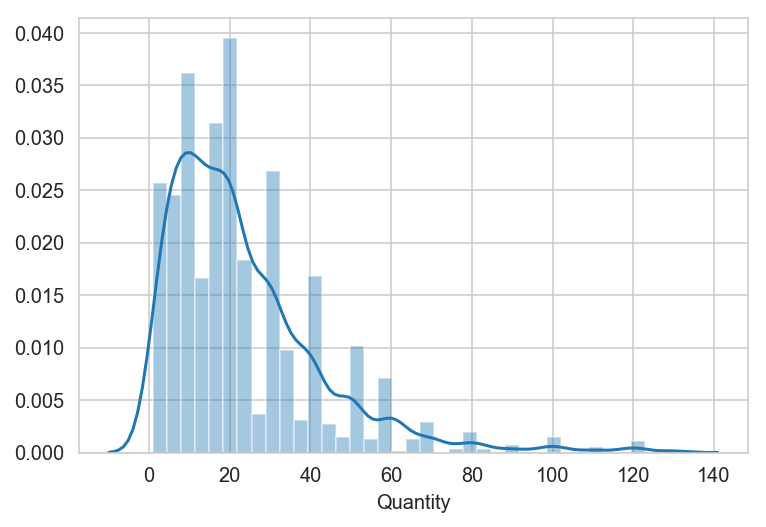

Sample 2 P-value 4.3519853073007804e-44 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 

Levene test: We accept the null hypothesis that the variances of the populations equal 

Need to use the non-parametric test (Mann-WhitneyU) to determine the equivalence of the populations 

MWU: The U statistic is 465219.5, and the p-value is 0.01990546853117364
MWU: The MannWhitneyU p-value 0.01990546853117364 is less than alpha 0.05
MannWhitneyU test: We can reject the null hypothesis that the two populations are equal 

The average Quantity sold, without MSRP Discount is 24.533434650455927
The average Quantity sold, with MSRP Discount is 23.49632598530394


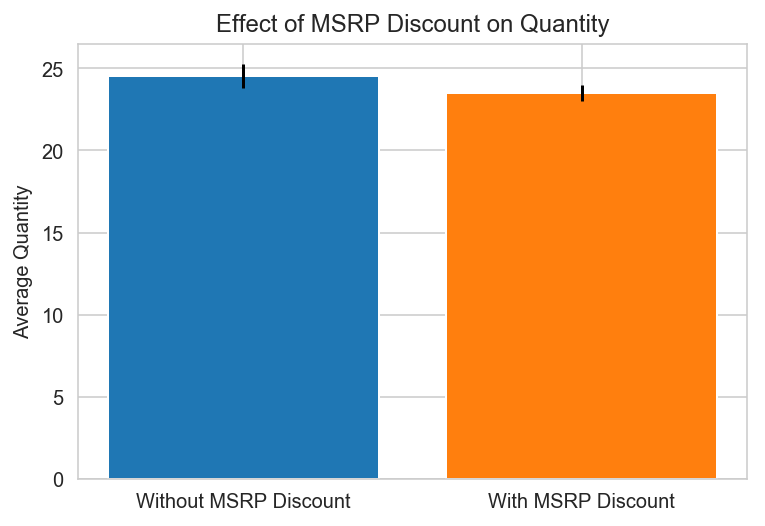

In [65]:
no_MSRP_discount, with_MSRP_discount = two_sample_tests(order_product_df, "MSRP", 'Quantity')
plot_two_sample_tests(no_MSRP_discount, with_MSRP_discount, 'MSRP Discount', 'Quantity')


## With net discounts a higher quantity is sold

Number of datapoints in group 1, no net_discount = 915
Number of datapoints in group 2, with net_discount = 1240
Number of datapoints in the samples > 30, possible to assume normality through the Central Limit Theorem 

Check the normality anyway!


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


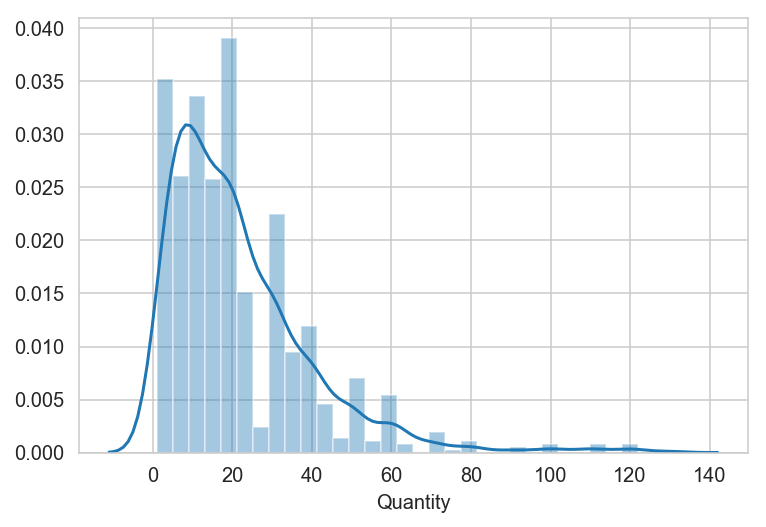

Sample 1 P-value 9.269039017041992e-89 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



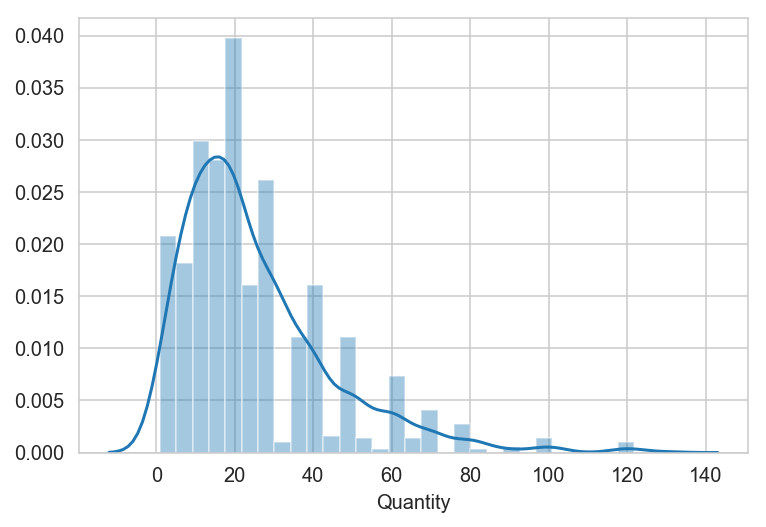

Sample 2 P-value 9.269039017041992e-89 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 

Levene test: We accept the null hypothesis that the variances of the populations equal 

Need to use the non-parametric test (Mann-WhitneyU) to determine the equivalence of the populations 

MWU: The U statistic is 494688.0, and the p-value is 1.7358140845437264e-07
MWU: The MannWhitneyU p-value 1.7358140845437264e-07 is less than alpha 0.05
MannWhitneyU test: We can reject the null hypothesis that the two populations are equal 

The average Quantity sold, without Net Discounts is 21.778142076502732
The average Quantity sold, with Net Discounts is 25.31451612903226


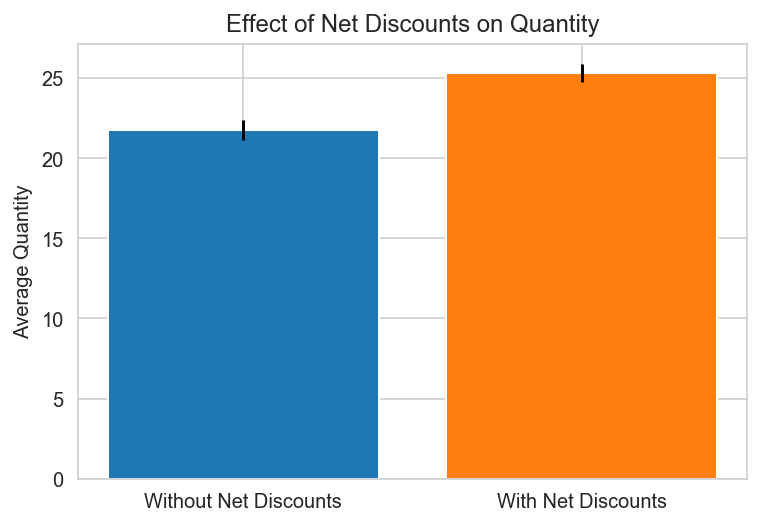

In [66]:
# Run the two_sample_tests to see if there is an Net Discount impact on Order Quantity or Total Product Spend ($)
no_discount, with_net_discount = two_sample_tests(order_product_df, 'net_discount', 'Quantity')

plot_two_sample_tests(no_discount, with_net_discount, 'Net Discounts', 'Quantity')

## With Net discounts the Total Product Spend is statistically equal to the Total product spend (revenue) without discounts.

## In other words,  it doesn't really pay off to offer discounts.

## However, this analysis does not reflect the entire picture. In the face of competitors who may offer discounts,  Northwind may have to offer discounts, simply to keep up the appearances with competitors, in order to get orders in the first place, without any increase in revenue

Number of datapoints in group 1, no net_discount = 915
Number of datapoints in group 2, with net_discount = 1240
Number of datapoints in the samples > 30, possible to assume normality through the Central Limit Theorem 

Check the normality anyway!


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


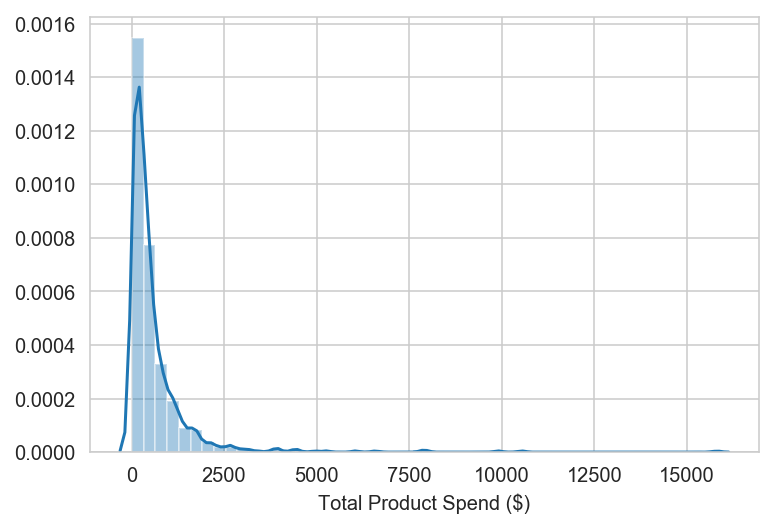

Sample 1 P-value 7.972762931381562e-264 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



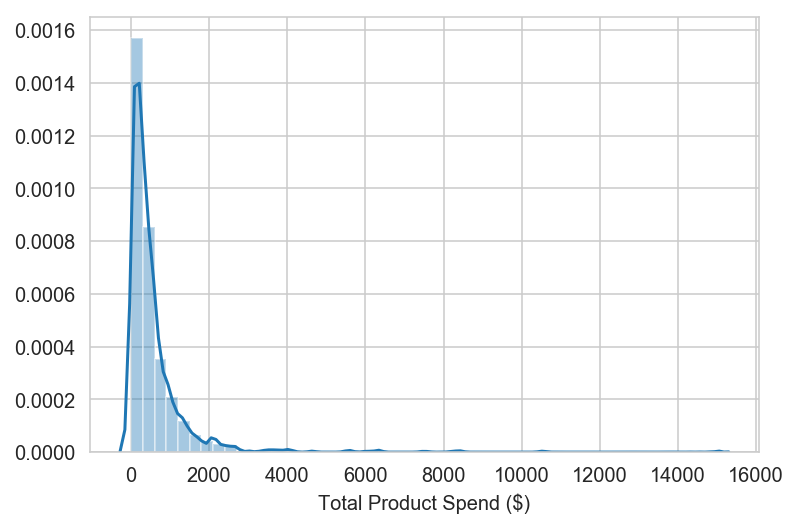

Sample 2 P-value 7.972762931381562e-264 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 

Levene test: We accept the null hypothesis that the variances of the populations equal 

Need to use the non-parametric test (Mann-WhitneyU) to determine the equivalence of the populations 

MWU: The U statistic is 564123.5, and the p-value is 0.41198294193148727
MannWhitneyU test: We can accept the null hypothesis that the two populations are equal 

The average Total Product Spend ($) sold, without Net Discounts is 608.5897377049181
The average Total Product Spend ($) sold, with Net Discounts is 571.7205076612905


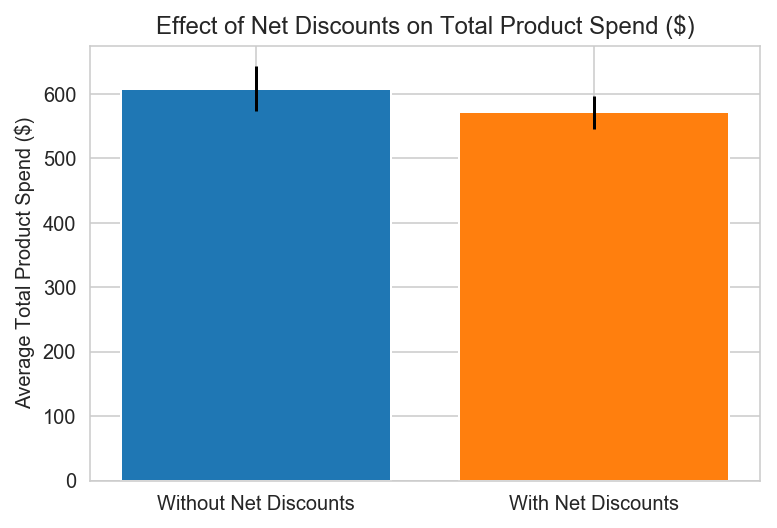

In [67]:
#Check the effect of Net Discounts on Total Product Spend
no_discount, with_net_discount = two_sample_tests(order_product_df, 'net_discount', 'Total Product Spend ($)')

plot_two_sample_tests(no_discount, with_net_discount, 'Net Discounts', 'Total Product Spend ($)')

In [68]:
'''Tukey tests show that none of the different discounts has a meaningful impact on the Total Product Spend
data = orderproduct_df['Quantity'].values 
labels = orderproduct_df['Net Discounts'].values

print(data), print(labels)

import statsmodels.api as sms

model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels) 
model.summary()'''

"Tukey tests show that none of the different discounts has a meaningful impact on the Total Product Spend\ndata = orderproduct_df['Quantity'].values \nlabels = orderproduct_df['Net Discounts'].values\n\nprint(data), print(labels)\n\nimport statsmodels.api as sms\n\nmodel = sms.stats.multicomp.pairwise_tukeyhsd(data,labels) \nmodel.summary()"

In [69]:
'''model.plot_simultaneous()
plt.ylabel('Net Discounts')
plt.xlabel('Quantity');'''

"model.plot_simultaneous()\nplt.ylabel('Net Discounts')\nplt.xlabel('Quantity');"

## Does selling at MSRP or non-MSRP prices affect the Quantity sold

Number of datapoints in group 1, no MSRP = 658
Number of datapoints in group 2, with MSRP = 1497
Number of datapoints in the samples > 30, possible to assume normality through the Central Limit Theorem 

Check the normality anyway!


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


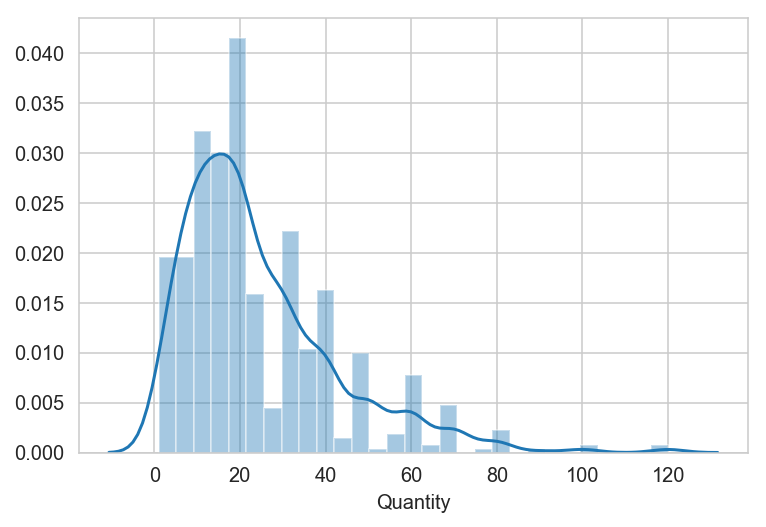

Sample 1 P-value 4.3519853073007804e-44 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



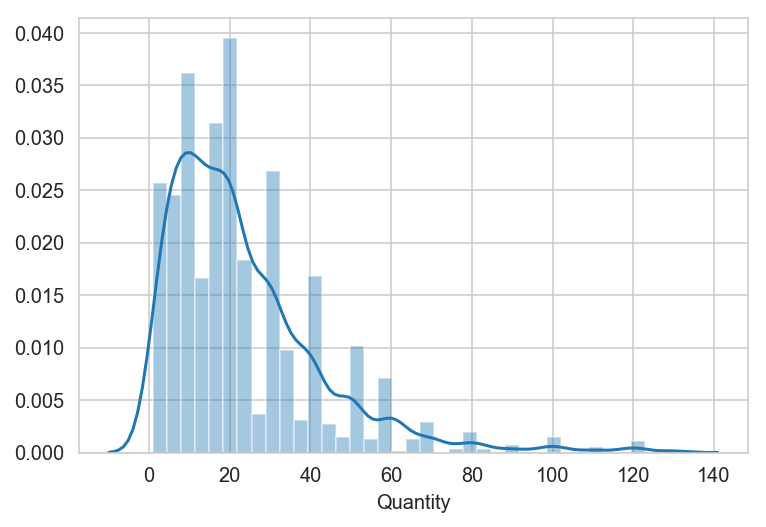

Sample 2 P-value 4.3519853073007804e-44 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 

Levene test: We accept the null hypothesis that the variances of the populations equal 

Need to use the non-parametric test (Mann-WhitneyU) to determine the equivalence of the populations 

MWU: The U statistic is 465219.5, and the p-value is 0.01990546853117364
MWU: The MannWhitneyU p-value 0.01990546853117364 is less than alpha 0.05
MannWhitneyU test: We can reject the null hypothesis that the two populations are equal 

The average Quantity sold, without MSRP is 24.533434650455927
The average Quantity sold, with MSRP is 23.49632598530394


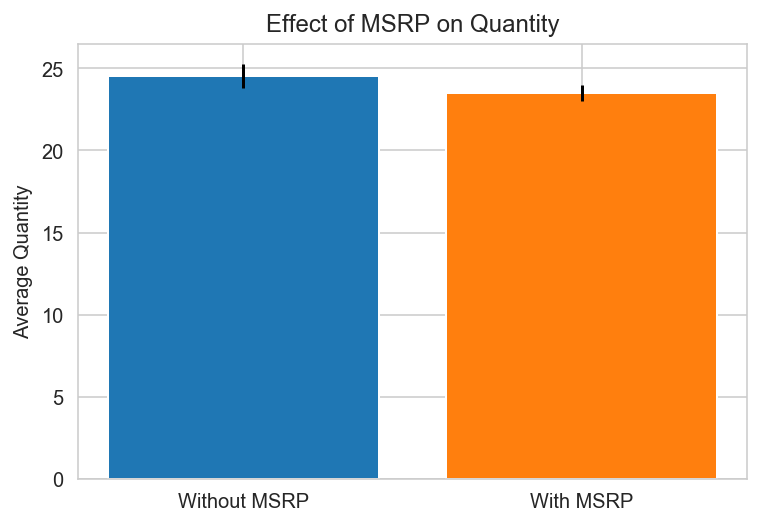

In [70]:
#Now let's check the impact of non_MSRP on the Order Quantity
Non_MSRP, MSRP = two_sample_tests(order_product_df, 'MSRP', 'Quantity')

plot_two_sample_tests(Non_MSRP, MSRP, 'MSRP', 'Quantity')




## Non-MSRP pricing (i.e. discounted pricing) has a significant impact on Quantity Sold

Number of datapoints in group 1, no MSRP = 658
Number of datapoints in group 2, with MSRP = 1497
Number of datapoints in the samples > 30, possible to assume normality through the Central Limit Theorem 

Check the normality anyway!


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


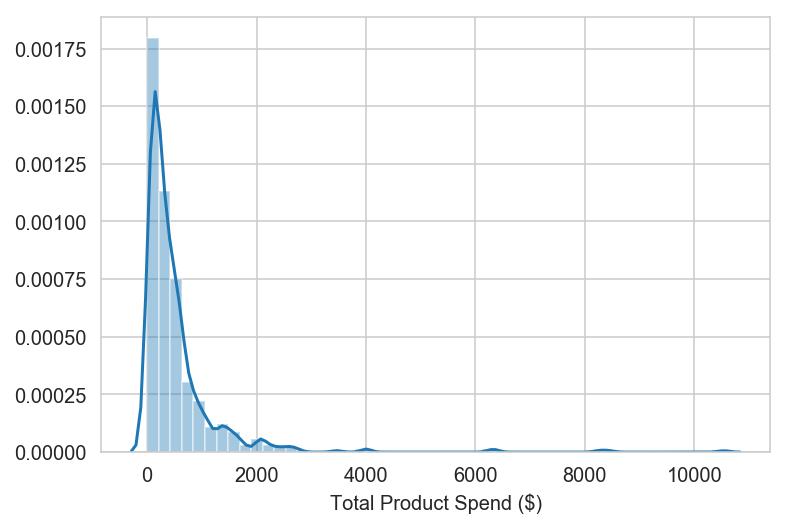

Sample 1 P-value 1.3828420073540596e-179 is less than alpha 0.05
Sample 1 Normality: We can reject the null hypothesis that the 1st sample comes from a normal distribution 



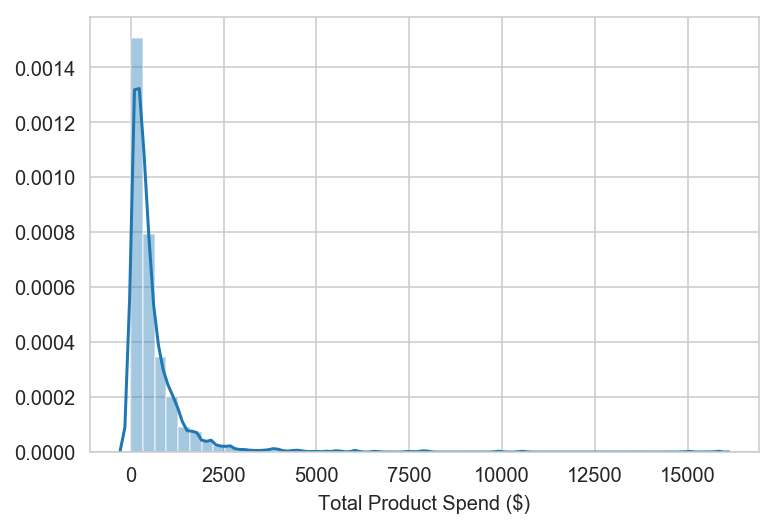

Sample 2 P-value 1.3828420073540596e-179 is less than alpha 0.05
Sample 2 Normality: We can reject the null hypothesis that the 2nd sample comes from a normal distribution 

Levene test: We accept the null hypothesis that the variances of the populations equal 

Need to use the non-parametric test (Mann-WhitneyU) to determine the equivalence of the populations 

MWU: The U statistic is 463835.0, and the p-value is 0.015554193286930031
MWU: The MannWhitneyU p-value 0.015554193286930031 is less than alpha 0.05
MannWhitneyU test: We can reject the null hypothesis that the two populations are equal 

The average Total Product Spent ($) sold, without MSRP is 532.5518161094229
The average Total Product Spent ($) sold, with MSRP is 611.4722408149636


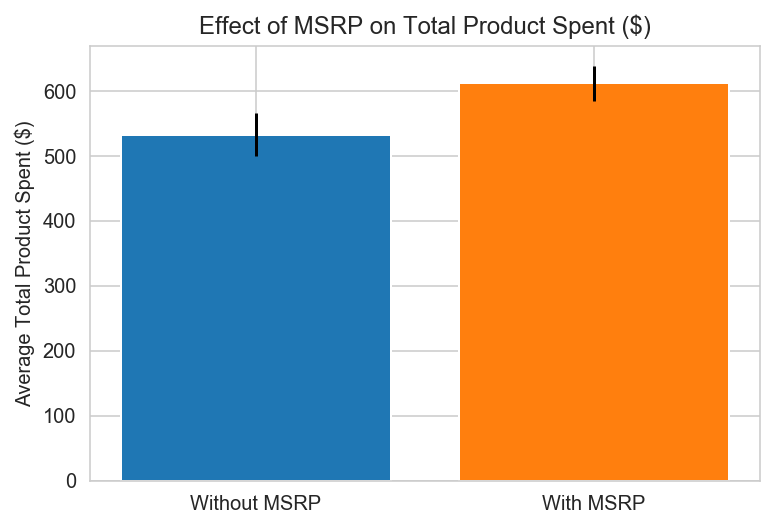

In [71]:
#Now let's check the impact of discounting price on the Order Quantity
Non_MSRP, MSRP = two_sample_tests(order_product_df, 'MSRP', 'Total Product Spend ($)')

plot_two_sample_tests(Non_MSRP, MSRP, 'MSRP', 'Total Product Spent ($)')

## The lower MSRP pricing doesn't improve the Total Product Spend -- i.e. the lower unit cost doesn't lead to increased unit spending

In [72]:
# We should try a tukey test to see if the Price or Discount has more significant effect
# For reference: order_product_df['Using MSRP'] = np.where(order_product_df["UnitPrice_x"] == order_product_df["UnitPrice_y"], 0, 1)
# orderdetail_df['discounted'] = np.where(orderdetail_df['Discount'] == 0,0,1)

# Keep track of populations with and without MSRP prices and with and without discounts

#display(order_product_df['MSRP Price'])

#order_product_df['MSRP, no discounts'] = df.groupby('discounted').get_group(0)[metric]
#group2 = df.groupby(feature).get_group(1)[metric]

# Hypothesis 4
## What is the impact of discounts on repeat purchasing ?
## First do feature engineering to determine which products have been repeatedly purchased by the same customer,  versus customers who didn't repeatedly buy

## The null hypothesis H0 is that discounts do not affect repeat buying
## The alternative hypothesis H1 is that discounts affect repeat buys



In [73]:
order_product_df.head()

,Id_x,OrderId,ProductId,UnitPrice_x,Quantity,Discount,Discounts,Final Price,Total Product Spend ($),Id_y,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_y,Net Discounts,net_discount,MSRP Discount,MSRP
0,10248/11,10248,11,14.00,12,0.00,0,14.00,168.00,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.33,1,0.33,0
1,10296/11,10296,11,16.80,12,0.00,0,16.80,201.60,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.20,1,0.20,0
2,10327/11,10327,11,16.80,50,0.20,1,13.44,672.00,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.36,1,0.20,0
3,10353/11,10353,11,16.80,12,0.20,1,13.44,161.28,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.36,1,0.20,0
4,10365/11,10365,11,16.80,24,0.00,0,16.80,403.20,11,Queso Cabrales,5,4,1 kg pkg.,21.00,0.20,1,0.20,0


In [74]:
order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,ShipName,ShipRegion,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,Vins et alcools Chevalier,Western Europe,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,Toms Spezialitäten,Western Europe,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,Hanari Carnes,South America,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,Victuailles en stock,Western Europe,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,Suprêmes délices,Western Europe,Belgium


In [75]:
#Join the order_df table to the order_product_df table to get more information regarding customers and ship dates

orderproduct_df = order_product_df.merge(order_df, left_on='OrderId', right_on='Id')
orderproduct_df.shape


(2155, 29)

In [98]:
## Remove columns which do not provide needed info at this point
repeat_customer = orderproduct_df.drop(columns = ['ShipVia', 'ShipName', 'ShipRegion', 'ShipCountry' ])

repeat_customer.groupby(['CustomerId', 'ProductName']).count()

product_count = 0

for customer in repeat_customer:
    

Id_x  OrderId  ProductId  \
CustomerId ProductName                                                  
ALFKI      Aniseed Syrup                        1        1          1   
           Chartreuse verte                     1        1          1   
           Escargots de Bourgogne               1        1          1   
           Flotemysost                          1        1          1   
           Grandma's Boysenberry Spread         1        1          1   
           Lakkalikööri                         1        1          1   
           Original Frankfurter grüne Soße      1        1          1   
           Raclette Courdavault                 1        1          1   
           Rössle Sauerkraut                    2        2          2   
           Spegesild                            1        1          1   
           Vegie-spread                         1        1          1   
ANATR      Camembert Pierrot                    1        1          1   
           Gudbrandsdalsost                     1        1          1   
           Konbu                                1        1          1   
           Mascarpone Fabioli                   1        1          1   
           Mozzarella di Giovanni               1        1          1   
           Outback Lager                        1        1          1   
           Queso Cabrales                       1        1          1   
           Singaporean Hokkien Fried Mee        1        1          1   
           Teatime Chocolate Biscuits           1        1          1   
           Tofu                                 1        1          1   
ANTO       Alice Mutton                         1        1          1   
           Boston Crab Meat                     1        1          1   
           Chang                                1        1          1   
           Chocolade                            1        1          1   
           Geitost                              2        2          2   
           Gumbär Gummibärchen                  1        1          1   
           Ipoh Coffee                          1        1          1   
           Louisiana Hot Spiced Okra            1        1          1   
           Perth Pasties                        1        1          1   
...                                           ...      ...        ...   
WILMK      Chai                                 1        1          1   
           Guaraná Fantástica                   1        1          1   
           Ipoh Coffee                          1        1          1   
           Lakkalikööri                         1        1          1   
           Louisiana Fiery Hot Pepper Sauce     1        1          1   
           Maxilaku                             1        1          1   
           Northwoods Cranberry Sauce           1        1          1   
           Pavlova                              1        1          1   
           Pâté chinois                         1        1          1   
           Queso Manchego La Pastora            1        1          1   
           Raclette Courdavault                 1        1          1   
           Rössle Sauerkraut                    1        1          1   
           Singaporean Hokkien Fried Mee        1        1          1   
           Sir Rodney's Scones                  1        1          1   
           Sirop d'érable                       1        1          1   
           Teatime Chocolate Biscuits           1        1          1   
WOLZA      Camembert Pierrot                    1        1          1   
           Chai                                 1        1          1   
           Chang                                2        2          2   
           Escargots de Bourgogne               1        1          1   
           Gorgonzola Telino                    1        1          1   
           Guaraná Fantástica                   1        1          1   
           Longlife Tofu      

# Extra Stuff

In [76]:
select_data = 'SELECT * FROM OrderDetail WHERE Discount >0;'
orderdetail_discounted_df = load_data(select_data)
orderdetail_discounted_df.head()


Size of the dataframe =  (838, 6)
Number of null data
Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64
Number of duplicated data =  0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.40,35,0.15
1,10250/65,10250,65,16.80,15,0.15
2,10251/22,10251,22,16.80,6,0.05
3,10251/57,10251,57,15.60,15,0.05
4,10252/20,10252,20,64.80,40,0.05


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.40,35,0.15
1,10250/65,10250,65,16.80,15,0.15
2,10251/22,10251,22,16.80,6,0.05
3,10251/57,10251,57,15.60,15,0.05
4,10252/20,10252,20,64.80,40,0.05


In [77]:
select_data = 'SELECT * FROM OrderDetail WHERE Discount = 0;'
orderdetail_nodisc_df = load_data(select_data)
orderdetail_nodisc_df.head()


Size of the dataframe =  (1317, 6)
Number of null data
Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64
Number of duplicated data =  0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00


In [78]:
#select_data2 = """SELECT od.Id, od.OrderId, od.ProductId, od.UnitPrice, od.Quantity, od.Discount, "Order".CustomerId, "Order".EmployeeId, "Order".OrderDate, p.ProductName, p.SupplierId, p.Category.Id, p.QuantityPerUnit, p.UnitPrice, p.UnitPrice, p.Discontinued 
#FROM OrderDetail as od, "Order" as o, Product as p 
#WHERE  od.OrderId= "Order".Id od.ProductId = p.Id;"""
#new_df = load_data(select_data2)
#new_df.head()

In [79]:
select_data = 'SELECT * FROM OrderDetail od JOIN "Order" ON od.OrderId = "Order".Id JOIN Product p ON od.ProductId = p.Id;'
ordetail_ord_prod_df = load_data(select_data)
ordetail_ord_prod_df.head()

Size of the dataframe =  (2155, 30)
Number of null data
Id                  0
OrderId             0
ProductId           0
UnitPrice           0
Quantity            0
Discount            0
Id                  0
CustomerId          0
EmployeeId          0
OrderDate           0
RequiredDate        0
ShippedDate        73
ShipVia             0
Freight             0
ShipName            0
ShipAddress         0
ShipCity            0
ShipRegion          0
ShipPostalCode     55
ShipCountry         0
Id                  0
ProductName         0
SupplierId          0
CategoryId          0
QuantityPerUnit     0
UnitPrice           0
UnitsInStock        0
UnitsOnOrder        0
ReorderLevel        0
Discontinued        0
dtype: int64
Number of duplicated data =  0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,CustomerId,EmployeeId,OrderDate,...,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10248/11,10248,11,14.00,12,0.00,10248,VINET,5,2012-07-04,...,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0
1,10248/42,10248,42,9.80,10,0.00,10248,VINET,5,2012-07-04,...,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
2,10248/72,10248,72,34.80,5,0.00,10248,VINET,5,2012-07-04,...,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0
3,10249/14,10249,14,18.60,9,0.00,10249,TOMSP,6,2012-07-05,...,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0
4,10249/51,10249,51,42.40,40,0.00,10249,TOMSP,6,2012-07-05,...,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,CustomerId,EmployeeId,OrderDate,...,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10248/11,10248,11,14.00,12,0.00,10248,VINET,5,2012-07-04,...,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0
1,10248/42,10248,42,9.80,10,0.00,10248,VINET,5,2012-07-04,...,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
2,10248/72,10248,72,34.80,5,0.00,10248,VINET,5,2012-07-04,...,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0
3,10249/14,10249,14,18.60,9,0.00,10249,TOMSP,6,2012-07-05,...,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0
4,10249/51,10249,51,42.40,40,0.00,10249,TOMSP,6,2012-07-05,...,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0


In [80]:
ordetail_ord_prod_df.groupby((ordetail_ord_prod_df["ProductId"], 
                               ordetail_ord_prod_df['CustomerId'])).mean()

C:\Users\zachmih\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


OrderId  ProductId  UnitPrice  Quantity  Discount  \
ProductId CustomerId                                                       
1         BERGS      10,689.00       1.00      18.00     35.00      0.25   
          BLONP      10,628.00       1.00      18.00     25.00      0.00   
          BOTTM      10,918.00       1.00      18.00     60.00      0.25   
          CHOPS      10,370.00       1.00      14.40     15.00      0.15   
          DUMO       10,609.00       1.00      18.00      3.00      0.00   
          EASTC      11,047.00       1.00      18.00     25.00      0.25   
          GODOS      10,911.00       1.00      18.00     10.00      0.00   
          GREAL      11,006.00       1.00      18.00      8.00      0.00   
          HILAA      10,863.00       1.00      18.00     20.00      0.15   
          HUNGO      10,646.00       1.00      18.00     15.00      0.25   
          LAMAI      10,413.00       1.00      14.40     24.00      0.00   
          LEHMS      10,796.00       1.00      18.00     40.00      0.17   
          LINOD      10,783.50       1.00      18.00     27.00      0.12   
          LONEP      10,317.00       1.00      14.40     20.00      0.00   
          MEREP      10,590.00       1.00      18.00     20.00      0.00   
          NORTS      10,752.00       1.00      18.00      8.00      0.00   
          PERIC      10,354.00       1.00      14.40     12.00      0.00   
          PRINI      10,477.00       1.00      14.40     15.00      0.00   
          QUEE       10,406.00       1.00      14.40     10.00      0.00   
          QUICK      10,488.00       1.00      16.20     37.50      0.10   
          RATTC      10,294.00       1.00      14.40     18.00      0.00   
          SAVEA      10,859.33       1.00      18.00     43.33      0.13   
          SEVES      10,869.00       1.00      18.00     40.00      0.00   
          SUPRD      11,035.00       1.00      18.00     10.00      0.00   
          THECR      11,003.00       1.00      18.00      4.00      0.00   
          TORTU      10,576.00       1.00      18.00     10.00      0.00   
          WANDK      10,348.00       1.00      14.40     15.00      0.15   
          WARTH      10,775.50       1.00      18.00      9.00      0.12   
          WELLI      10,920.00       1.00      18.00     20.50      0.03   
          WILMK      11,005.00       1.00      18.00      2.00      0.00   
...                        ...        ...        ...       ...       ...   
76        VAFFE      10,399.00      76.00      14.40     35.00      0.00   
          WILMK      10,879.00      76.00      18.00     10.00      0.00   
77        ALFKI      10,835.00      77.00      13.00      2.00      0.20   
          COMMI      10,290.00      77.00      10.40     10.00      0.00   
          FRANK      10,929.00      77.00      13.00     15.00      0.00   
          FRANS      11,060.00      77.00      13.00     10.00      0.00   
          FURIB      10,491.00      77.00      10.40      7.00      0.15   
          GALED      10,366.00      77.00      10.40      5.00      0.00   
          HANAR      10,788.00      77.00      13.00     35.00      0.12   
          HILAA      10,257.00      77.00      10.40     15.00      0.00   
          HUNGO      10,646.00      77.00      13.00     35.00      0.25   
          LAUGB      10,495.00      77.00      10.40      5.00      0.00   
          LEHMS      10,497.00      77.00      10.40     25.00      0.00   
          LETSS      10,735.00      77.00      13.00      2.00      0.10   
          LILAS      10,801.50      77.00      13.00     15.00      0.05   
          MEREP      10,590.00      77.00      13.00     60.00      0.05   
          OCEA       10,986.00      77.00      13.00     15.00      0.00   
          OTTIK      10,776.50      77.00      13.00     15.50      0.05   
          QUEDE      10,504.00      77.00      11.70     15.00      0.07   
          QUEE       11,068.00      77.00      13.00     28.00      0.1

In [81]:
#ordetail_ord_prod_df.groupby((ordetail_ord_prod_df["ProductId"], 
#                               ordetail_ord_prod_df['CustomerId'],
#                            ordetail_ord_prod_df['Id'])).mean()

In [82]:
select_data = 'SELECT * FROM OrderDetail o JOIN Product p ON o.ProductID = p.ID WHERE Discount =0;'
orderdetail_product_nodisc_df = load_data(select_data)
orderdetail_product_nodisc_df.head(1400)

Size of the dataframe =  (1317, 16)
Number of null data
Id                 0
OrderId            0
ProductId          0
UnitPrice          0
Quantity           0
Discount           0
Id                 0
ProductName        0
SupplierId         0
CategoryId         0
QuantityPerUnit    0
UnitPrice          0
UnitsInStock       0
UnitsOnOrder       0
ReorderLevel       0
Discontinued       0
dtype: int64
Number of duplicated data =  0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10248/11,10248,11,14.00,12,0.00,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0
1,10248/42,10248,42,9.80,10,0.00,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
2,10248/72,10248,72,34.80,5,0.00,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0
3,10249/14,10249,14,18.60,9,0.00,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0
4,10249/51,10249,51,42.40,40,0.00,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10248/11,10248,11,14.00,12,0.00,11,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0
1,10248/42,10248,42,9.80,10,0.00,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
2,10248/72,10248,72,34.80,5,0.00,72,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0
3,10249/14,10249,14,18.60,9,0.00,14,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0
4,10249/51,10249,51,42.40,40,0.00,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0
5,10250/41,10250,41,7.70,10,0.00,41,Jack's New England Clam Chowder,19,8,12 - 12 oz cans,9.65,85,0,10,0
6,10251/65,10251,65,16.80,20,0.00,65,Louisiana Fiery Hot Pepper Sauce,2,2,32 - 8 oz bottles,21.05,76,0,0,0
7,10252/60,10252,60,27.20,40,0.00,60,Camembert Pierrot,28,4,15 - 300 g rounds,34.00,19,0,0,0
8,10253/31,10253,31,10.00,20,0.00,31,Gorgonzola Telino,14,4,12 - 100 g pkgs,12.50,0,70,20,0
9,10253/39,10253,39,14.40,42,0.00,39,Chartreuse verte,18,1,750 cc per bottle,18.00,69,0,5,0


In [83]:
select_data = 'SELECT * FROM OrderDetail o JOIN Product p ON o.ProductID = p.ID WHERE Discount >0;'
orderdetail_product_disc_df = load_data(select_data)
orderdetail_product_disc_df.head(838)

Size of the dataframe =  (838, 16)
Number of null data
Id                 0
OrderId            0
ProductId          0
UnitPrice          0
Quantity           0
Discount           0
Id                 0
ProductName        0
SupplierId         0
CategoryId         0
QuantityPerUnit    0
UnitPrice          0
UnitsInStock       0
UnitsOnOrder       0
ReorderLevel       0
Discontinued       0
dtype: int64
Number of duplicated data =  0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10250/51,10250,51,42.40,35,0.15,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0
1,10250/65,10250,65,16.80,15,0.15,65,Louisiana Fiery Hot Pepper Sauce,2,2,32 - 8 oz bottles,21.05,76,0,0,0
2,10251/22,10251,22,16.80,6,0.05,22,Gustaf's Knäckebröd,9,5,24 - 500 g pkgs.,21.00,104,0,25,0
3,10251/57,10251,57,15.60,15,0.05,57,Ravioli Angelo,26,5,24 - 250 g pkgs.,19.50,36,0,20,0
4,10252/20,10252,20,64.80,40,0.05,20,Sir Rodney's Marmalade,8,3,30 gift boxes,81.00,40,0,0,0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10250/51,10250,51,42.40,35,0.15,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0
1,10250/65,10250,65,16.80,15,0.15,65,Louisiana Fiery Hot Pepper Sauce,2,2,32 - 8 oz bottles,21.05,76,0,0,0
2,10251/22,10251,22,16.80,6,0.05,22,Gustaf's Knäckebröd,9,5,24 - 500 g pkgs.,21.00,104,0,25,0
3,10251/57,10251,57,15.60,15,0.05,57,Ravioli Angelo,26,5,24 - 250 g pkgs.,19.50,36,0,20,0
4,10252/20,10252,20,64.80,40,0.05,20,Sir Rodney's Marmalade,8,3,30 gift boxes,81.00,40,0,0,0
5,10252/33,10252,33,2.00,25,0.05,33,Geitost,15,4,500 g,2.50,112,0,20,0
6,10254/24,10254,24,3.60,15,0.15,24,Guaraná Fantástica,10,1,12 - 355 ml cans,4.50,20,0,0,1
7,10254/55,10254,55,19.20,21,0.15,55,Pâté chinois,25,6,24 boxes x 2 pies,24.00,115,0,20,0
8,10258/2,10258,2,15.20,50,0.20,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
9,10258/5,10258,5,17.00,65,0.20,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


# Notes


Start of analysis section


C:\Users\zachmih\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


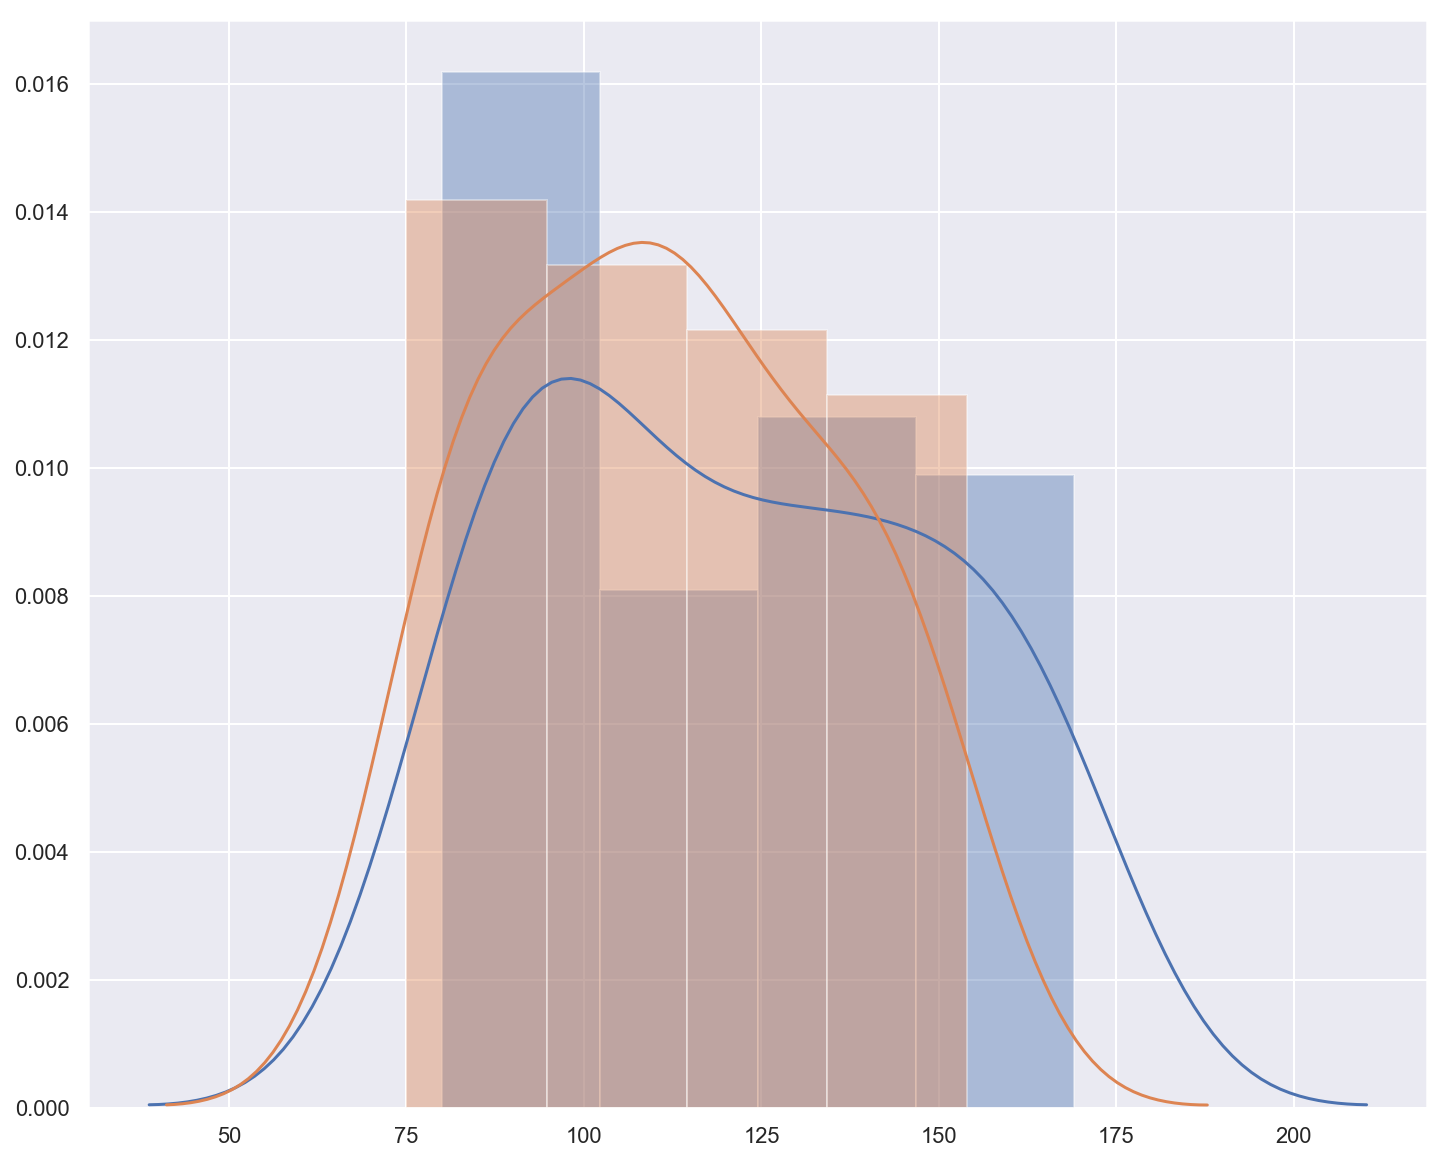

In [84]:
# Set up arrays for 2 sample T test to see impact of discount

control = np.array([166, 165, 120,  94, 104, 166,  98,  85,  97,  87, 114, 100, 152,
                    87, 152, 102,  82,  80,  84, 109,  98, 154, 135, 164, 137, 128,
                    122, 146,  86, 146,  85, 101, 109, 105, 163, 136, 142, 144, 140,
                    128, 126, 119, 121, 126, 169,  87,  97, 167,  89, 155])

experimental = np.array([ 83, 100, 123,  75, 130,  77,  78,  87, 116, 116, 141,  93, 107,
                         101, 142, 152, 130, 123, 122, 154, 119, 149, 106, 107, 108, 151,
                         97,  95, 104, 141,  80, 110, 136, 134, 142, 135, 111,  83,  86,
                         116,  86, 117,  87, 143, 104, 107,  86,  88, 124,  76])

# Create a plot showing overlapping of distribution means and sds for inspection
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control)
sns.distplot(experimental)


In [85]:
def sample_variance(sample):
    sample_mean = np.mean(sample)
    return np.sum((sample - sample_mean)**2)/ (len(sample) - 1)
    

In [86]:
def pooled_variance(sample1, sample2):
    n1, n2 = len(sample1), len(sample2)
    var1, var2 = sample_variance(sample1), sample_variance(sample2)
    return ((n1-1) * var1 + (n2-1) * var2) / ((n1 + n2) - 2)

In [87]:
def twosample_tstatistic(expr, ctrl):
    exp_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    pool_var = pooled_variance(expr, ctrl)
    n_e, n_c = len(expr), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(pool_var * ((1/n_e)+(1/n_c)))
    return num/denom

t_stat = twosample_tstatistic(experimental, control)
t_stat
# -1.8915462966190268

-1.8915462966190273

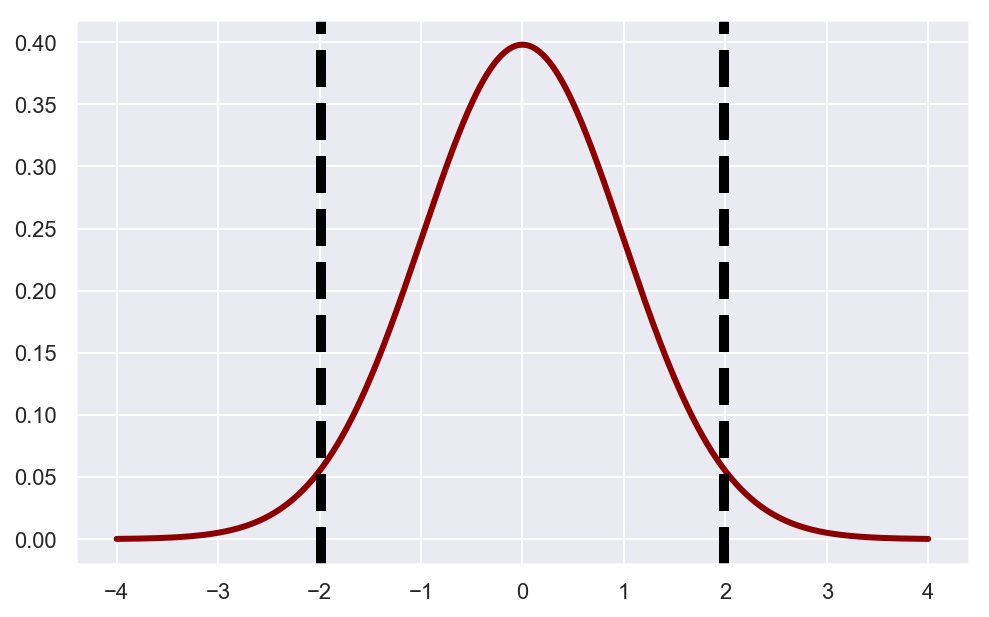

In [88]:
# Visualize t and p_value

def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)
        
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    crit = stats.t.ppf(1-0.025, (n_control + n_experimental - 2))
    
    
    # Draw two sided boundary for critical-t
    ys = stats.t.pdf(xs, (n_control + n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color = 'darkred')
    
    ax.axvline(crit, color = 'black', linestyle = '--', lw = 5)
    ax.axvline(-crit, color = 'black', linestyle = '--', lw = 5)
    plt.show()
    return None

n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)

In [89]:
## Calculate p_value
# Lower tail comulative density function returns area under the lower tail curve
lower_tail = stats.t.cdf(-1.89, (50+50-2), 0, 1)
# Upper tail comulative density function returns area under upper tail curve
upper_tail = 1. - stats.t.cdf(1.89, (50+50-2), 0, 1)

p_value = lower_tail+upper_tail
print(p_value)

0.061713104303855605


In [90]:
## your code here
def type_1_error(population, num_tests, alpha_set):
    
    columns = ['type_1_error', 'p_value', 'alpha']
    sig_test = pd.DataFrame(columns=columns)
    counter = 0

for i in range(1,num_tests + 1):

    for alpha in alpha_set:
        samp1 = np.random.choice(population, 100, replace = True)
        samp2 = np.random.choice(population, 100, replace = True)
        
        results = stats.ttest_ind(samp1, samp2)
        if result[1] < alpha:
            sig_tests.loc[counter] = [1,results[1], alpha]
        else:
            sig_tests.loc[counter] = [0, results[1], alpha]
            
        counter += 1
        
return sig_test
'''
Calculates the t-test for the means of *two independent* samples of scores.

This is a two-sided test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.
'''
#
#stats.ttest_ind(experimental, control)

NameError: name 'num_tests' is not defined

In [ ]:
lower_bound = exp_cdf(7,5)
upper_bound  = exp_cdf(7,8)

print("Probability of earthquake before 5 weeks: {}%".format(lower_bound * 100))
print("Probability of earthquake before 8 weeks: {}%".format(upper_bound * 100))
print("Probability of earthquake between 5 - 8 weeks: {}%".format((upper_bound - lower_bound) * 100))

# Expected Output: 
# 
# Probability of earthquake before 5 weeks: 51.045834044304684%
# Probability of earthquake before 8 weeks: 68.10934426760295%
# Probability of earthquake between 5 - 8 weeks: 17.063510223298273%

In [ ]:
# Standard Normal Distribution - Normalization procedure
mean1, sd1 = 5, 3 # dist 1 
mean2, sd2 = 10, 2 # dist 2 
d1 = np.random.normal(mean1, sd1, 1000)
d2 = np.random.normal(mean2, sd2, 1000)
sns.distplot(d1);
sns.distplot(d2);

In [ ]:
# Stardardizing and visualizing distributions

sns.distplot([(x - d1.mean())/d1.std() for x in d1]);
sns.distplot([(x - d2.mean())/d2.std() for x in d2]);

# Northwind Sales Background information

The Deliverables
The goal of your project is to query the database to get the data needed to perform a statistical analysis. In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

##### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In addition to answering this question with a hypothesis test, you will also need to come up with at least 3 other hypotheses to test on your own. These can by anything that you think could be imporant information for the company.

For this hypothesis, be sure to specify both the null hypothesis and the alternative hypothesis for your question. You should also specify if this is one-tail or a two-tail test.

For online students, there will be four deliverables for this project:

1) A Jupyter Notebook containing any code you've written for this project. This work will need to be pushed to your GitHub repository in order to submit your project.

2) An organized README.md file in the GitHub repository that describes the contents of the repository. This file should be the source of information for navigating through the repository.

3) A Blog Post.

4) An "Executive Summary" PowerPoint Presentation that explains the hypothesis tests you ran, your findings, and their relevance to company stakeholders.

Jupyter Notebook Must-Haves
For this project, your Jupyter Notebook should meet the following specifications

Organization/Code Cleanliness

The notebook should be well organized, easy to follow, and code is commented where appropriate.

* Level Up: The notebook contains well-formatted, professional looking markdown cells explaining any substantial code. All functions have docstrings that act as professional-quality documentation.

* The notebook is written to technical audiences with a way to both understand your approach and reproduce your results. The target audience for this deliverable is other data scientists looking to validate your findings.

* Any SQL code written to source data should also be included.

Findings

Your notebook should clearly show how you arrived at your results for each hypothesis test, including how you calculated your p-values.

* You should also include any other statistics that you find relevant to your analysis, such as effect size.